# 0. Library Import

In [1]:
import numpy
import pandas

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 1. Visualization Configuration

In [2]:
%matplotlib inline
plt.rcParams['font.size'] = 20
plt.rcParams["figure.figsize"] = (50, 30)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams["axes.grid"] = True

In [3]:
%%html
<style>
    table { display: inline-block }
    .rendered_html td, .rendered_html th { text-align: left; }
</style>

# 2. KOSPI Sharp Ratio

,eod_date,item_code,price_close,updown_price,updown_ratio,trade_count,trade_amount
0,20010102,KOSPI,520.95,16.33,3.24,231014.0,1223328.0
1,20010103,KOSPI,521.43,0.48,0.09,324584.0,1583403.0
2,20010104,KOSPI,558.02,36.59,7.02,444540.0,2984762.0
3,20010105,KOSPI,580.85,22.83,4.09,578286.0,3569582.0
4,20010108,KOSPI,586.65,5.80,1.00,558645.0,2948092.0
...,...,...,...,...,...,...,...
5432,20221223,KOSPI,2313.69,43.04,-1.83,366988.0,5935798.0
5433,20221226,KOSPI,2317.14,3.45,0.15,427844.0,5205750.0
5434,20221227,KOSPI,2332.79,15.65,0.68,448498.0,7126994.0
5435,20221228,KOSPI,2280.45,52.34,-2.24,405893.0,7566892.0


,YYYYMM,PRICE_FIRST,PRICE_LAST,PROFIT,VARIANCE,Sharp-Ratio,Sharp-Ratio-Sum
24,200301,635.17,591.86,-0.068186,0.103533,-0.658599,-0.658599
25,200302,600.41,575.43,-0.041605,0.093826,-0.443426,-1.102025
26,200303,590.04,535.70,-0.092095,0.127474,-0.722466,-1.824491
27,200304,538.56,599.35,0.112875,0.121403,0.929757,-0.894733
28,200305,597.44,633.42,0.060224,0.081633,0.737736,-0.156997
...,...,...,...,...,...,...,...
259,202208,2452.25,2472.05,0.008074,0.049112,0.164405,47.430459
260,202209,2415.61,2155.49,-0.107683,0.067859,-1.586864,45.843595
261,202210,2209.38,2293.61,0.038124,0.065292,0.583898,46.427493
262,202211,2335.22,2472.53,0.058800,0.060610,0.970130,47.397623


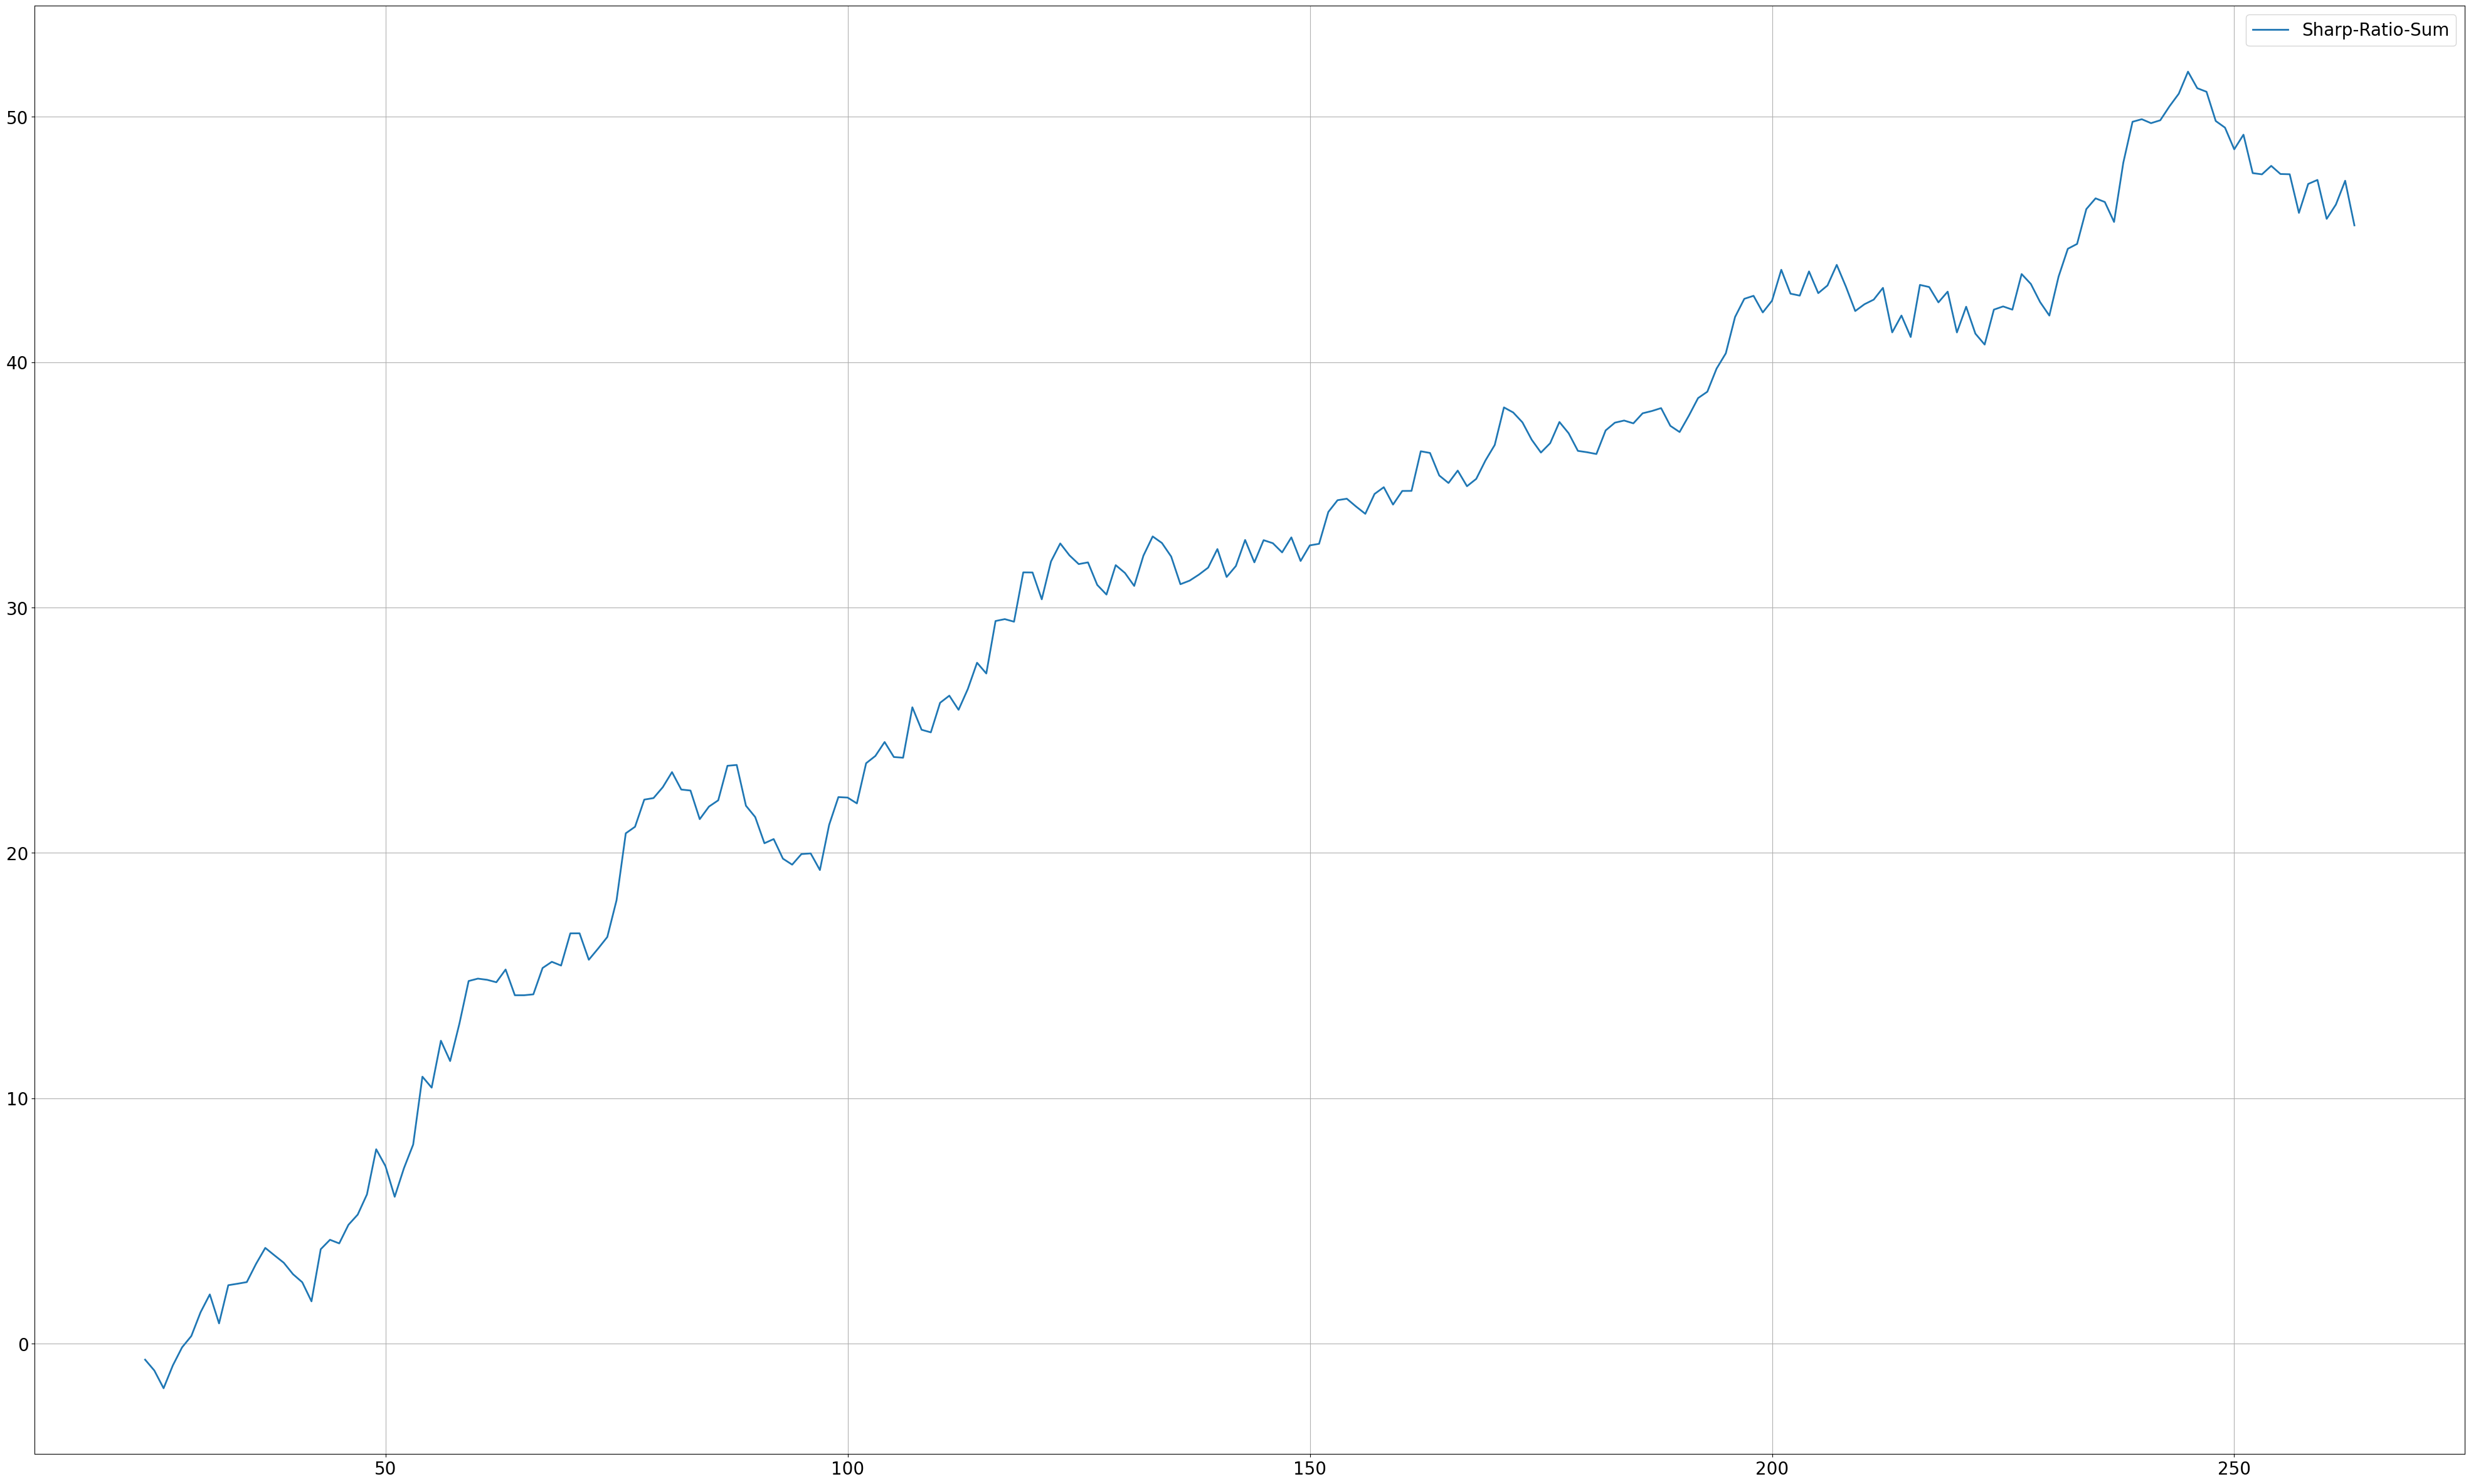

In [4]:
df_kospi = pandas.read_csv('./data-0102-kospi.csv')
display(df_kospi)
df_kospi = df_kospi.sort_values(by=['eod_date'], ascending=True)
df_kospi = df_kospi[['eod_date', 'price_close']]
df_kospi['yyyymm'] = df_kospi['eod_date']
df_kospi['yyyymm'] = df_kospi['yyyymm'].astype(str)
df_kospi['yyyymm'] = df_kospi['yyyymm'].str[0:6]

df_kospi['price_yesterday'] = df_kospi['price_close'].shift(1)
df_kospi = df_kospi.tail(df_kospi.shape[0] - 1)
df_kospi['profit'] = (df_kospi['price_close'] - df_kospi['price_yesterday']) / df_kospi['price_yesterday']

list_kospi_sharp = list()
for yyyymm in df_kospi['yyyymm'].unique():
    df_kospi_part = df_kospi[df_kospi['yyyymm'] == yyyymm]
    price_tail = float(df_kospi_part.tail(1)['price_close'].tolist()[0])
    price_head = float(df_kospi_part.head(1)['price_close'].tolist()[0])
    list_kospi_sharp.append({
        'YYYYMM': int(yyyymm),
        'PRICE_FIRST': price_head,
        'PRICE_LAST': price_tail,
        'PROFIT': (price_tail - price_head) / price_head,
        # 'PROFIT': numpy.mean(df_kospi_part['profit']) * 30,
        'VARIANCE': numpy.std(df_kospi_part['profit']) * numpy.sqrt(30),
    })
df_kospi_sharp = pandas.DataFrame(list_kospi_sharp)
df_kospi_sharp = df_kospi_sharp[df_kospi_sharp['YYYYMM'] >= 200301]
df_kospi_sharp['Sharp-Ratio'] = df_kospi_sharp['PROFIT'] / df_kospi_sharp['VARIANCE']
df_kospi_sharp['Sharp-Ratio-Sum'] = df_kospi_sharp['Sharp-Ratio'].cumsum()
display(df_kospi_sharp)
df_kospi_sharp.to_csv('data-0301-kospi.csv', index=None)
df_kospi_sharp_plot = df_kospi_sharp[['Sharp-Ratio-Sum']]
df_kospi_sharp_plot.plot()
df_all = df_kospi_sharp[['YYYYMM', 'Sharp-Ratio-Sum']]
df_all.columns = ['YYYYMM', 'KOSPI']
df_all = df_all.set_index(['YYYYMM'])

# 3. Equal Weight Portfolio Sharp Ratio

In [5]:
def asset_allocation(p_args):
    l_dict_price = p_args['prices']
    l_dict_asset_count = p_args['asset_count']
    l_dict_asset_ratio = p_args['asset_ratio']
    l_total_amount = p_args['asset_amount']
    l_asset_code = p_args['asset_list']
    l_balance_code = p_args['balance_code']
    l_std_date = p_args['std_date']

    sum_to_modify_amount = 0

    dict_asset_new = dict()
    dict_need_to_modify = dict()
    for equity_code in l_asset_code:
        asset_new = (l_total_amount + l_dict_asset_count[l_balance_code]) * l_dict_asset_ratio[equity_code]
        asset_previous = l_dict_asset_count[equity_code]
        try:
            dict_asset_new[equity_code] = int(asset_new / l_dict_price[equity_code])
        except:
            import sys
            print(l_std_date, equity_code, l_dict_price[equity_code])
            sys.exit(1)
        dict_need_to_modify[equity_code] = int(asset_new / l_dict_price[equity_code]) - asset_previous
        sum_to_modify_amount += dict_need_to_modify[equity_code] * l_dict_price[equity_code]

    # 조정 대상 금액이 잔액보다 크면, (잔액 + sum(보유수량*시가)) 규모에서 조정
    if sum_to_modify_amount > l_dict_asset_count[l_balance_code]:
        # print('Re-ALLOCATION')
        total_asset_new = l_dict_asset_count[l_balance_code]
        for equity_code in l_asset_code:
            total_asset_new += l_dict_asset_count[equity_code] * l_dict_price[equity_code]

        sum_to_modify_amount = 0
        for equity_code in l_asset_code:
            asset_new = total_asset_new * l_dict_asset_ratio[equity_code]
            asset_previous = l_dict_asset_count[equity_code]
            dict_asset_new[equity_code] = int(asset_new / l_dict_price[equity_code])
            dict_need_to_modify[equity_code] = int(asset_new / l_dict_price[equity_code]) - asset_previous
            sum_to_modify_amount += dict_need_to_modify[equity_code] * l_dict_price[equity_code]

    for equity_code in l_asset_code:
        dict_asset_new[equity_code] = l_dict_asset_count[equity_code] + dict_need_to_modify[equity_code]
    dict_asset_new[l_balance_code] = l_dict_asset_count[l_balance_code] - sum_to_modify_amount

    return dict_asset_new

df_prices = pandas.read_csv('data-0201-base.csv')
df_prices = df_prices.set_index(['기준일자'])

# 종가로 판단해서 수량을 설정하고,
# 시가로 수량을 조정하고,
# 조정 후 수량을 종가로 평가한다.
list_code = [
    'A005930', 'A000660', 'A006400', 'A005380', 'A000270',
    'A005490', 'A012330', 'A015760', 'A033780', 'A003550'
]
balance_code = 'A999999'
invest_amount = 1000000000

# 총 자산금액
asset_amount = 0
# 조정 후 목표 비율: 종목 / 비율
dict_asset_ratio = dict()
# 현재 보유 자산: 종목 / 보유 수량
dict_asset_count = dict()
for equity_code in list_code:
    dict_asset_ratio[equity_code] = 0.1
    dict_asset_count[equity_code] = 0
dict_asset_count[balance_code] = invest_amount

day_to_start = 20030101
day_to_finish = 20221229
asset_amount = 0
loop_count = 0
prev_A005930_price = 0
prev_A000660_price = 0
prev_A006400_price = 0
prev_A005380_price = 0
prev_A000270_price = 0
prev_A005490_price = 0
prev_A012330_price = 0
prev_A015760_price = 0
prev_A033780_price = 0
prev_A003550_price = 0

list_ew = list()
for eod_date, row in df_prices.iterrows():
    if eod_date < day_to_start:
        continue
    if eod_date > day_to_finish:
        continue
    # 판단을 위한 가격
    df_asset = df_prices[df_prices.index <= eod_date]
    df_asset_today = df_asset.tail(1)
    df_asset_yesterday = df_asset.tail(2).head(1)

    dict_price_curr_C = dict()
    dict_price_curr_C['A005930'] = float(df_asset_today['A005930-삼성전자-종가'].tolist()[0])
    dict_price_curr_C['A000660'] = float(df_asset_today['A000660-SK하이닉스-종가'].tolist()[0])
    dict_price_curr_C['A006400'] = float(df_asset_today['A006400-삼성SDI-종가'].tolist()[0])
    dict_price_curr_C['A005380'] = float(df_asset_today['A005380-현대차-종가'].tolist()[0])
    dict_price_curr_C['A000270'] = float(df_asset_today['A000270-기아-종가'].tolist()[0])
    dict_price_curr_C['A005490'] = float(df_asset_today['A005490-POSCO홀딩스-종가'].tolist()[0])
    dict_price_curr_C['A012330'] = float(df_asset_today['A012330-현대모비스-종가'].tolist()[0])
    dict_price_curr_C['A015760'] = float(df_asset_today['A015760-한국전력-종가'].tolist()[0])
    dict_price_curr_C['A033780'] = float(df_asset_today['A033780-KT&G-종가'].tolist()[0])
    dict_price_curr_C['A003550'] = float(df_asset_today['A003550-LG-종가'].tolist()[0])

    dict_price_curr_O = dict()
    dict_price_curr_O['A005930'] = float(df_asset_today['A005930-삼성전자-시가'].tolist()[0])
    dict_price_curr_O['A000660'] = float(df_asset_today['A000660-SK하이닉스-시가'].tolist()[0])
    dict_price_curr_O['A006400'] = float(df_asset_today['A006400-삼성SDI-시가'].tolist()[0])
    dict_price_curr_O['A005380'] = float(df_asset_today['A005380-현대차-시가'].tolist()[0])
    dict_price_curr_O['A000270'] = float(df_asset_today['A000270-기아-시가'].tolist()[0])
    dict_price_curr_O['A005490'] = float(df_asset_today['A005490-POSCO홀딩스-시가'].tolist()[0])
    dict_price_curr_O['A012330'] = float(df_asset_today['A012330-현대모비스-시가'].tolist()[0])
    dict_price_curr_O['A015760'] = float(df_asset_today['A015760-한국전력-시가'].tolist()[0])
    dict_price_curr_O['A033780'] = float(df_asset_today['A033780-KT&G-시가'].tolist()[0])
    dict_price_curr_O['A003550'] = float(df_asset_today['A003550-LG-시가'].tolist()[0])

    if dict_price_curr_O['A005930'] == 0:
        dict_price_curr_O['A005930'] = prev_A005930_price
    else:
        prev_A005930_price = float(df_asset_today['A005930-삼성전자-시가'].tolist()[0])
    if dict_price_curr_O['A000660'] == 0:
        dict_price_curr_O['A000660'] = prev_A000660_price
    else:
        prev_A000660_price = float(df_asset_today['A000660-SK하이닉스-시가'].tolist()[0])
    if dict_price_curr_O['A006400'] == 0:
        dict_price_curr_O['A006400'] = prev_A006400_price
    else:
        prev_A006400_price = float(df_asset_today['A006400-삼성SDI-시가'].tolist()[0])
    if dict_price_curr_O['A005380'] == 0:
        dict_price_curr_O['A005380'] = prev_A005380_price
    else:
        prev_A005380_price = float(df_asset_today['A005380-현대차-시가'].tolist()[0])
    if dict_price_curr_O['A000270'] == 0:
        dict_price_curr_O['A000270'] = prev_A000270_price
    else:
        prev_A000270_price = float(df_asset_today['A000270-기아-시가'].tolist()[0])
    if dict_price_curr_O['A005490'] == 0:
        dict_price_curr_O['A005490'] = prev_A005490_price
    else:
        prev_A005490_price = float(df_asset_today['A005490-POSCO홀딩스-시가'].tolist()[0])
    if dict_price_curr_O['A012330'] == 0:
        dict_price_curr_O['A012330'] = prev_A012330_price
    else:
        prev_A012330_price = float(df_asset_today['A012330-현대모비스-시가'].tolist()[0])
    if dict_price_curr_O['A015760'] == 0:
        dict_price_curr_O['A015760'] = prev_A015760_price
    else:
        prev_A015760_price = float(df_asset_today['A015760-한국전력-시가'].tolist()[0])
    if dict_price_curr_O['A033780'] == 0:
        dict_price_curr_O['A033780'] = prev_A033780_price
    else:
        prev_A033780_price = float(df_asset_today['A033780-KT&G-시가'].tolist()[0])
    if dict_price_curr_O['A003550'] == 0:
        dict_price_curr_O['A003550'] = prev_A003550_price
    else:
        prev_A003550_price = float(df_asset_today['A003550-LG-시가'].tolist()[0])
    dict_params = dict()
    dict_params['prices'] = dict_price_curr_O

    dict_params['asset_count'] = dict_asset_count
    dict_params['asset_ratio'] = dict_asset_ratio
    dict_params['asset_amount'] = asset_amount
    dict_params['asset_list'] = list_code
    dict_params['balance_code'] = balance_code
    dict_params['std_date'] = eod_date

    asset_amount = 0
    dict_asset_count = asset_allocation(dict_params)
    for equity_code in list_code:
        asset_amount += dict_asset_count[equity_code] * dict_price_curr_C[equity_code]

    '''
    for equity_code in list_code:
        print(
            # 종목코드
            equity_code, '\t',
            # 보유 수량
            dict_asset_count[equity_code], '\t',
            # 당일 시가
            dict_price_curr_O[equity_code], '\t',
            # 당일 종가
            dict_price_curr_C[equity_code], '\t',
            # 당일 평가금액
            dict_asset_count[equity_code] * dict_price_curr_C[equity_code], '\t'
            )
    '''
    # print('Date\t', eod_date, '\tBalance\t', dict_asset_count[balance_code], '\tAsset Amount\t', asset_amount)
    list_ew.append({
        'eod_date': eod_date,
        'asset-amount': asset_amount,
    })

    loop_count += 1
    if loop_count > 10:
        # break
        pass

df_ew = pandas.DataFrame(list_ew)
display(df_ew)

,eod_date,asset-amount
0,20030102,1.010217e+09
1,20030103,1.017118e+09
2,20030106,1.046863e+09
3,20030107,1.005485e+09
4,20030108,1.025681e+09
...,...,...
4942,20221223,1.469041e+10
4943,20221226,1.470608e+10
4944,20221227,1.464008e+10
4945,20221228,1.443659e+10


,YYYYMM,PRICE_FIRST,PRICE_LAST,PROFIT,VARIANCE,Sharp-Ratio,Sharp-Ratio-Sum
0,200301,1.017118e+09,9.266829e+08,-0.088913,0.120307,-0.739048,-0.739048
1,200302,9.482973e+08,9.117388e+08,-0.038552,0.105709,-0.364696,-1.103744
2,200303,9.407600e+08,8.734996e+08,-0.071496,0.115020,-0.621596,-1.725340
3,200304,8.636495e+08,9.978098e+08,0.155341,0.123933,1.253426,-0.471914
4,200305,9.911018e+08,1.055262e+09,0.064736,0.080282,0.806357,0.334443
...,...,...,...,...,...,...,...
235,202208,1.512278e+10,1.510926e+10,-0.000894,0.049647,-0.018008,56.631847
236,202209,1.483224e+10,1.373204e+10,-0.074176,0.051736,-1.433731,55.198115
237,202210,1.388120e+10,1.441832e+10,0.038694,0.061540,0.628753,55.826868
238,202211,1.465978e+10,1.549220e+10,0.056783,0.055762,1.018297,56.845165


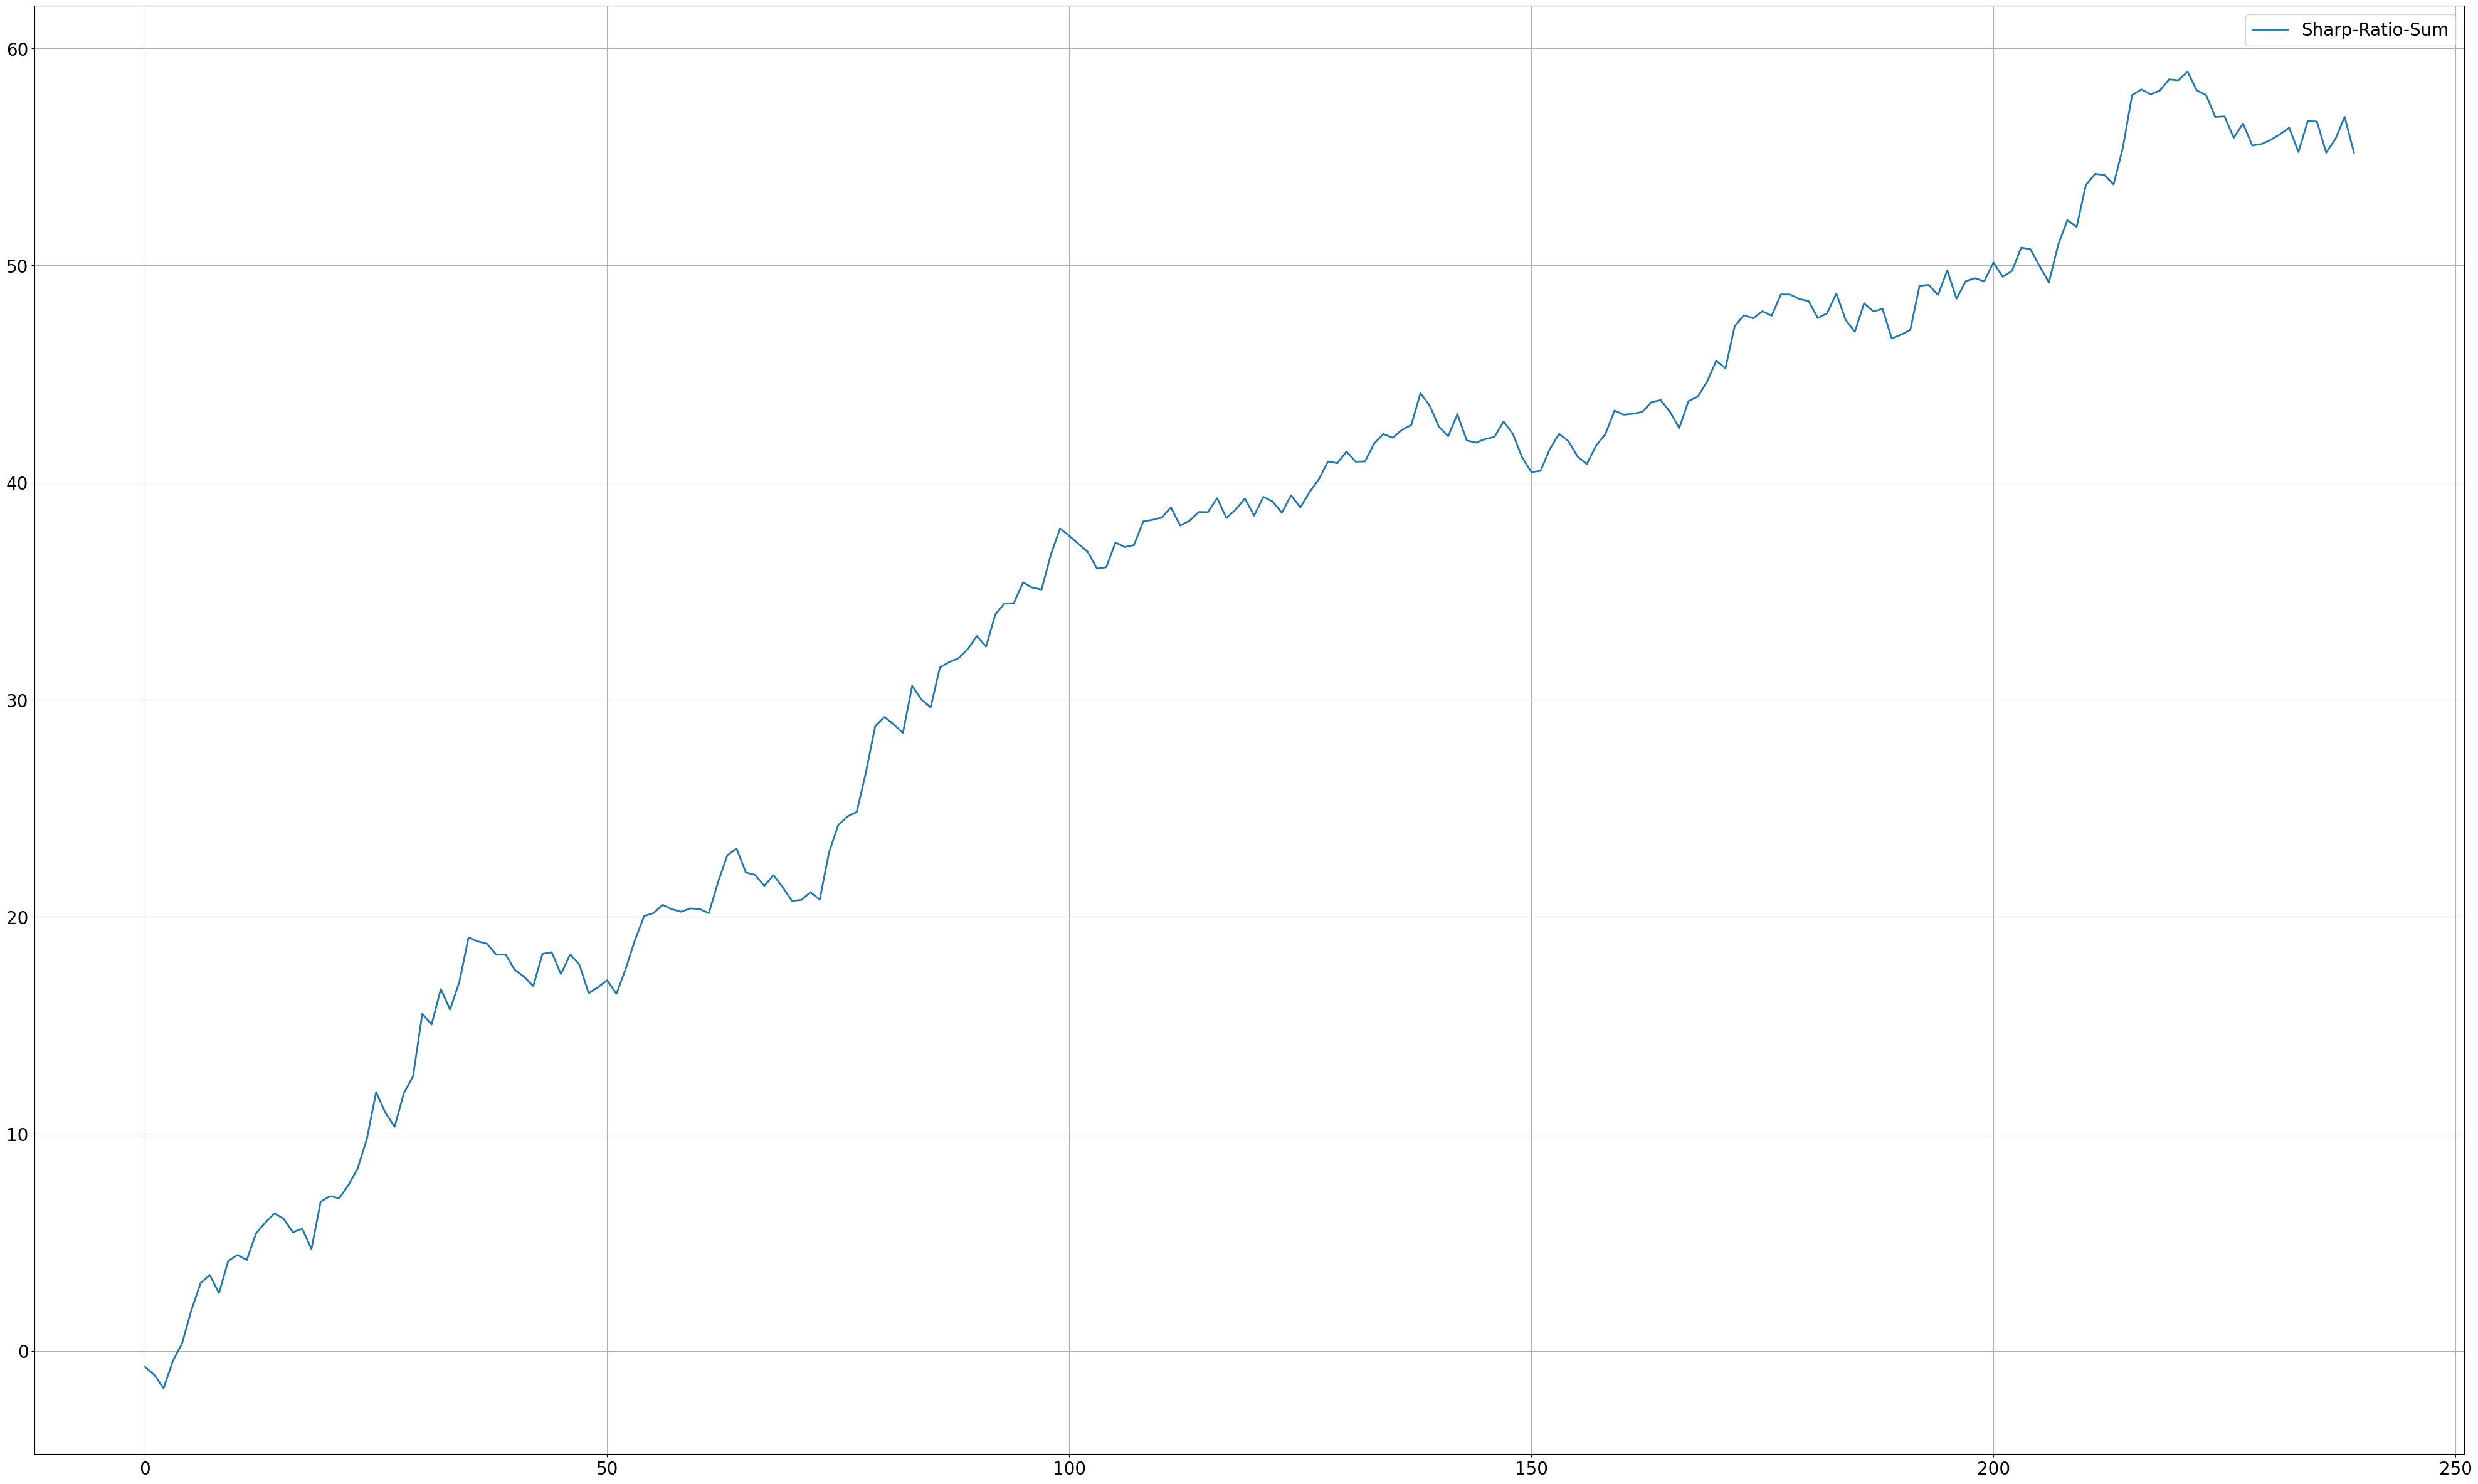

In [6]:
measure_name = 'asset-amount'

df_ew = df_ew.sort_values(by=['eod_date'], ascending=True)
df_ew['yyyymm'] = df_ew['eod_date']
df_ew['yyyymm'] = df_ew['yyyymm'].astype(str)
df_ew['yyyymm'] = df_ew['yyyymm'].str[0:6]

df_ew['yesterday'] = df_ew[measure_name].shift(1)
df_ew = df_ew.tail(df_ew.shape[0] - 1)
df_ew['profit'] = (df_ew[measure_name] - df_ew['yesterday']) / df_ew['yesterday']

list_ew_sharp = list()
for yyyymm in df_ew['yyyymm'].unique():
    df_ew_part = df_ew[df_ew['yyyymm'] == yyyymm]
    price_tail = float(df_ew_part.tail(1)[measure_name].tolist()[0])
    price_head = float(df_ew_part.head(1)[measure_name].tolist()[0])
    list_ew_sharp.append({
        'YYYYMM': int(yyyymm),
        'PRICE_FIRST': price_head,
        'PRICE_LAST': price_tail,
        'PROFIT': (price_tail - price_head) / price_head,
        # 'PROFIT': numpy.mean(df_kospi_part['profit']) * 30,
        'VARIANCE': numpy.std(df_ew_part['profit']) * numpy.sqrt(30),
    })
df_ew_sharp = pandas.DataFrame(list_ew_sharp)
df_ew_sharp = df_ew_sharp[df_ew_sharp['YYYYMM'] >= 200301]
df_ew_sharp['Sharp-Ratio'] = df_ew_sharp['PROFIT'] / df_ew_sharp['VARIANCE']
df_ew_sharp['Sharp-Ratio-Sum'] = df_ew_sharp['Sharp-Ratio'].cumsum()
display(df_ew_sharp)
df_ew_sharp.to_csv('data-0302-ew.csv', index=None)
df_ew_sharp_plot = df_ew_sharp[['Sharp-Ratio-Sum']]
df_ew_sharp_plot.plot()

df_ew_result = df_ew_sharp[['YYYYMM', 'Sharp-Ratio-Sum']]
df_ew_result = df_ew_result.set_index(['YYYYMM'])
df_ew_result.columns = ['Equal-Weight']
df_all = df_all.join(df_ew_result, how='left')

<Axes: xlabel='ts'>

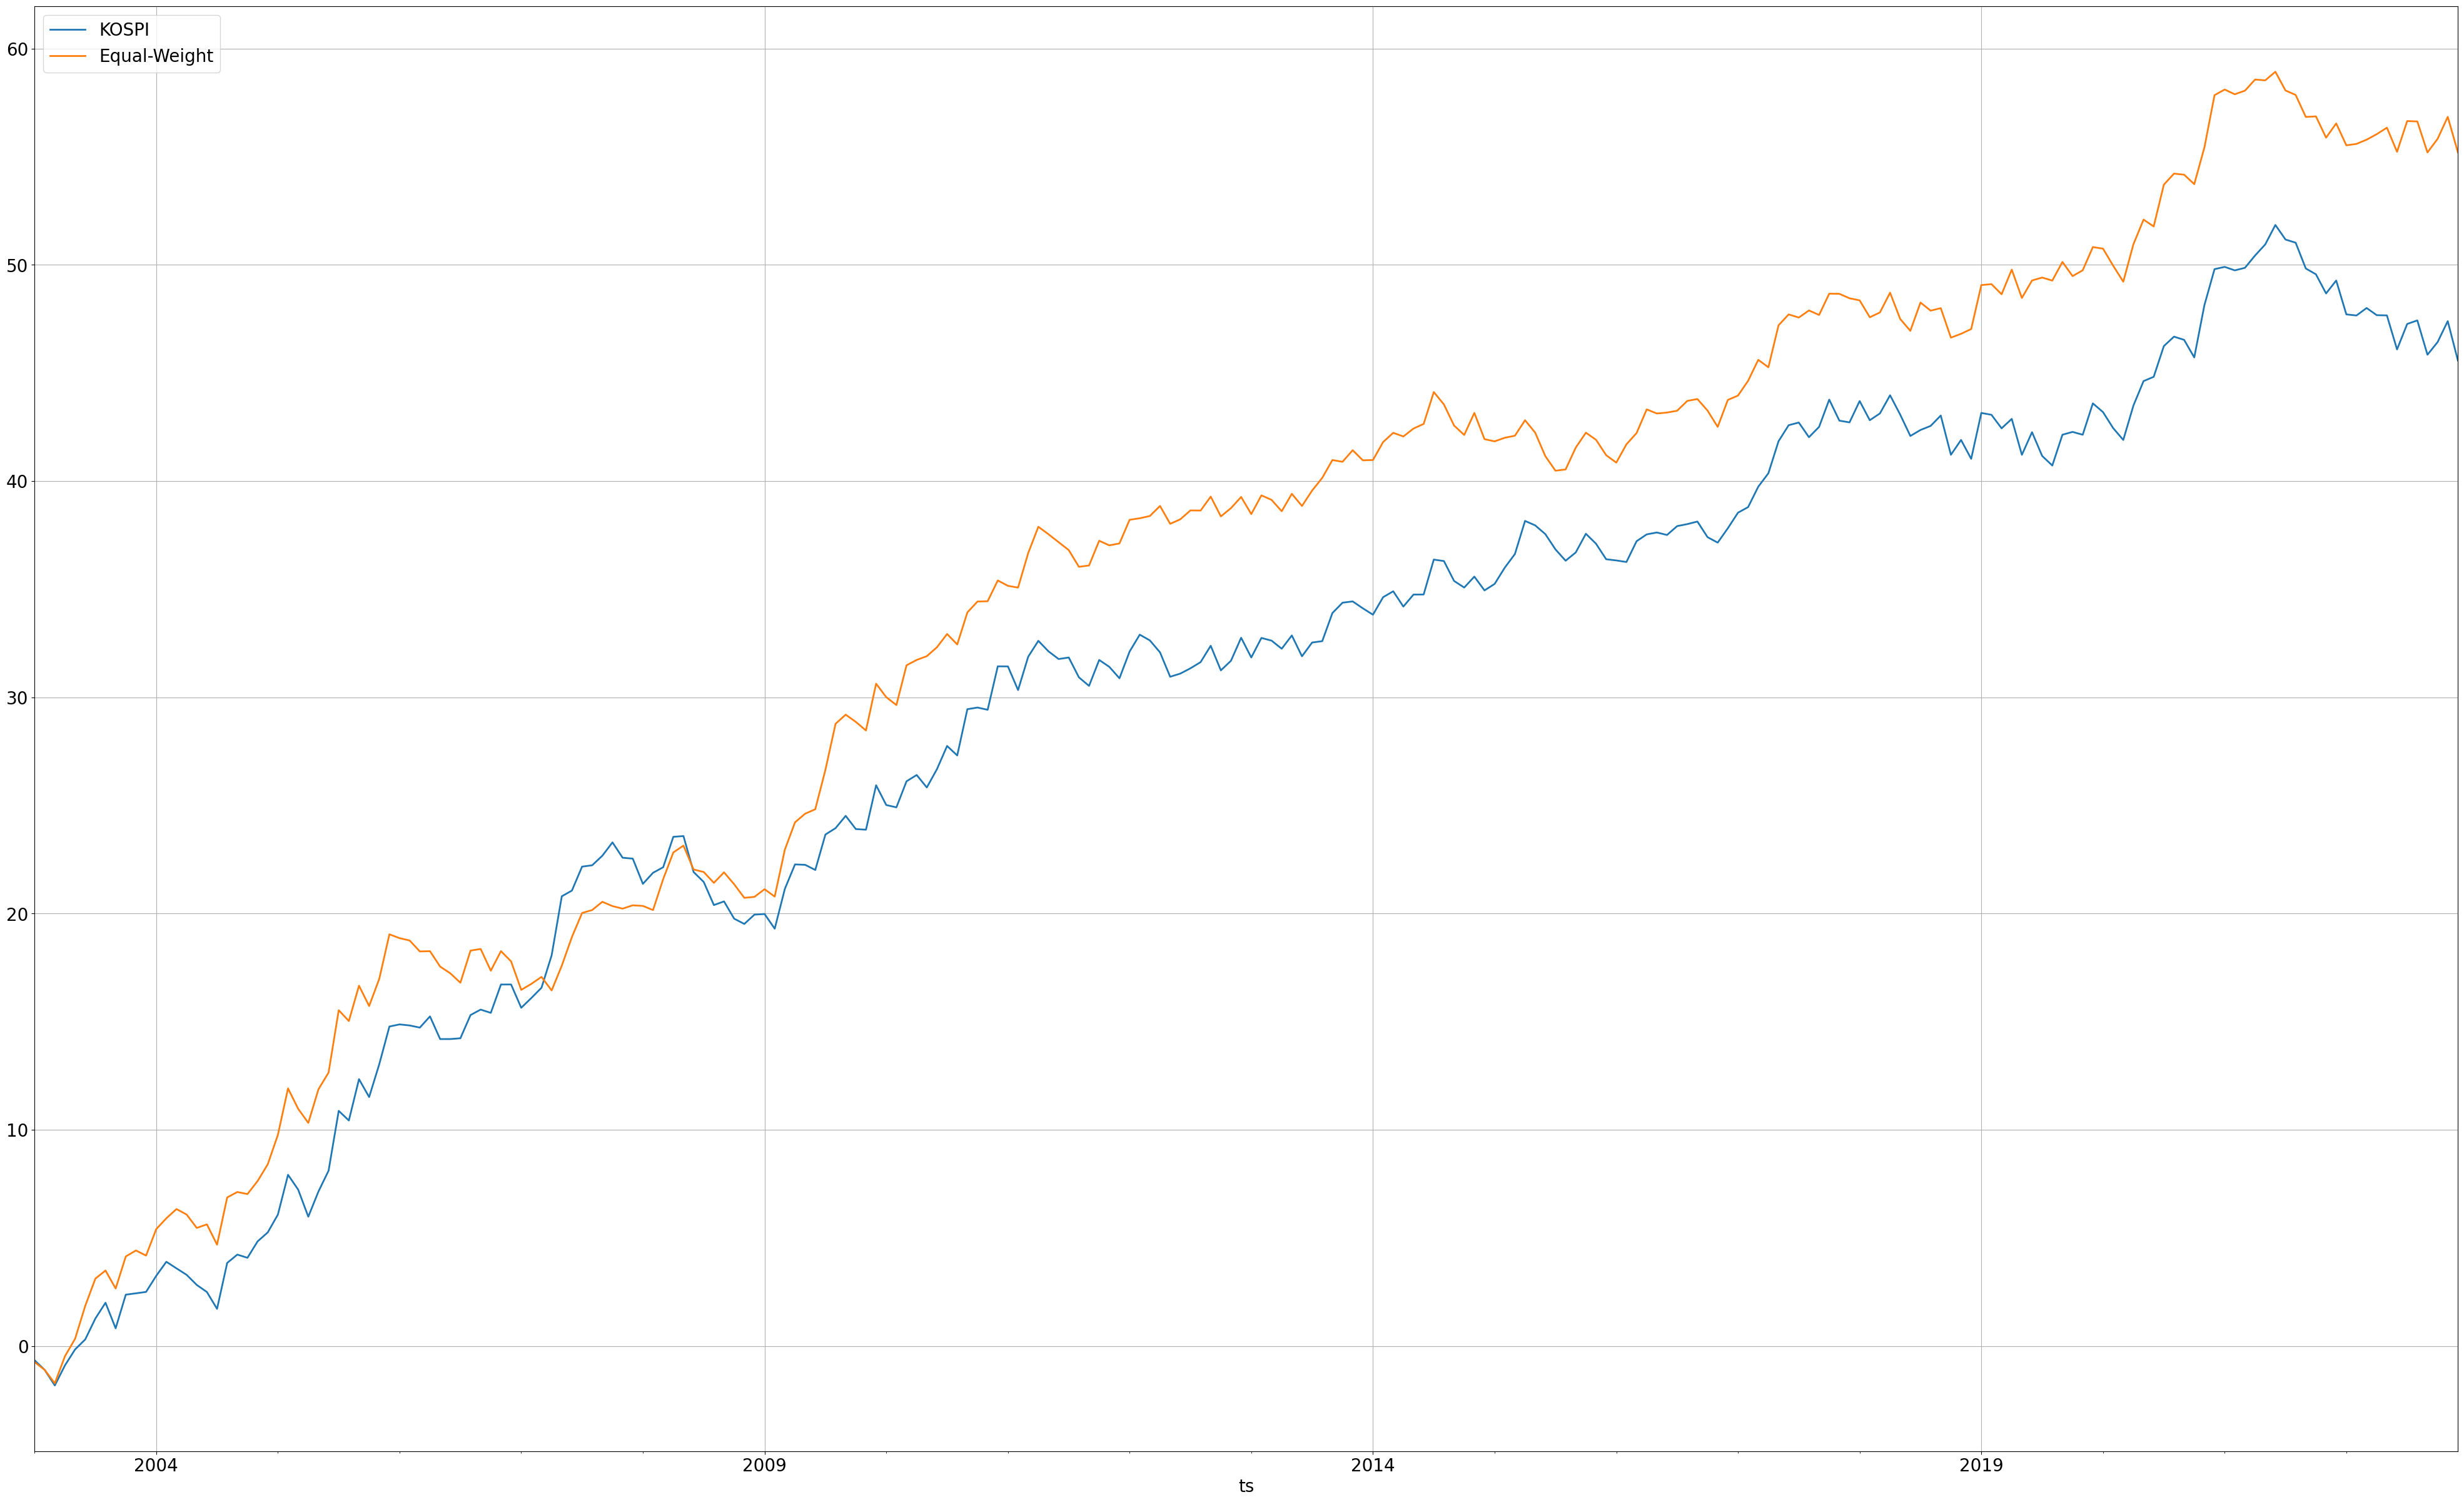

In [7]:
df_all_plot = df_all.copy()
df_all_plot['ts'] = pandas.to_datetime(df_all.index, format='%Y%m')
df_all_plot = df_all_plot.set_index(['ts'])
df_all_plot.plot()

# 4. Tangency Portfolio Sharp Ratio

In [8]:
def asset_allocation(p_args):
    l_dict_price = p_args['prices']
    l_dict_asset_count = p_args['asset_count']
    l_dict_asset_ratio = p_args['asset_ratio']
    l_total_amount = p_args['asset_amount']
    l_asset_code = p_args['asset_list']
    l_balance_code = p_args['balance_code']
    l_std_date = p_args['std_date']

    sum_to_modify_amount = 0

    dict_asset_new = dict()
    dict_need_to_modify = dict()
    for equity_code in l_asset_code:
        asset_new = (l_total_amount + l_dict_asset_count[l_balance_code]) * l_dict_asset_ratio[equity_code]
        asset_previous = l_dict_asset_count[equity_code]
        try:
            dict_asset_new[equity_code] = int(asset_new / l_dict_price[equity_code])
        except:
            import sys
            print(l_std_date, equity_code, l_dict_price[equity_code])
            sys.exit(1)
        dict_need_to_modify[equity_code] = int(asset_new / l_dict_price[equity_code]) - asset_previous
        sum_to_modify_amount += dict_need_to_modify[equity_code] * l_dict_price[equity_code]

    # 조정 대상 금액이 잔액보다 크면, (잔액 + sum(보유수량*시가)) 규모에서 조정
    if sum_to_modify_amount > l_dict_asset_count[l_balance_code]:
        # print('Re-ALLOCATION')
        total_asset_new = l_dict_asset_count[l_balance_code]
        for equity_code in l_asset_code:
            total_asset_new += l_dict_asset_count[equity_code] * l_dict_price[equity_code]

        sum_to_modify_amount = 0
        for equity_code in l_asset_code:
            asset_new = total_asset_new * l_dict_asset_ratio[equity_code]
            asset_previous = l_dict_asset_count[equity_code]
            dict_asset_new[equity_code] = int(asset_new / l_dict_price[equity_code])
            dict_need_to_modify[equity_code] = int(asset_new / l_dict_price[equity_code]) - asset_previous
            sum_to_modify_amount += dict_need_to_modify[equity_code] * l_dict_price[equity_code]

    for equity_code in l_asset_code:
        dict_asset_new[equity_code] = l_dict_asset_count[equity_code] + dict_need_to_modify[equity_code]
    dict_asset_new[l_balance_code] = l_dict_asset_count[l_balance_code] - sum_to_modify_amount

    return dict_asset_new

df_prices = pandas.read_csv('data-0201-base.csv')
df_prices = df_prices.set_index(['기준일자'])

# 종가로 판단해서 수량을 설정하고,
# 시가로 수량을 조정하고,
# 조정 후 수량을 종가로 평가한다.
list_code = [
    'A005930', 'A000660', 'A006400', 'A005380', 'A000270',
    'A005490', 'A012330', 'A015760', 'A033780', 'A003550'
]
balance_code = 'A999999'
invest_amount = 1000000000

# 총 자산금액
asset_amount = 0
# 조정 후 목표 비율: 종목 / 비율
dict_asset_ratio = dict()
# 현재 보유 자산: 종목 / 보유 수량
dict_asset_count = dict()
for equity_code in list_code:
    dict_asset_count[equity_code] = 0
dict_asset_count[balance_code] = invest_amount

df_mpt_a = pandas.read_csv('./data-0202-mpt-A.csv')
dict_cols = dict()
for col_name in df_mpt_a.columns:
    for code in list_code:
        if code in col_name:
            dict_cols[code] = col_name

day_to_start = 20030101
day_to_finish = 20221229
asset_amount = 0
loop_count = 0
prev_A005930_price = 0
prev_A000660_price = 0
prev_A006400_price = 0
prev_A005380_price = 0
prev_A000270_price = 0
prev_A005490_price = 0
prev_A012330_price = 0
prev_A015760_price = 0
prev_A033780_price = 0
prev_A003550_price = 0

list_mpt_a = list()
for eod_date, row in df_prices.iterrows():
    if eod_date < day_to_start:
        continue
    if eod_date > day_to_finish:
        continue

    df_mpt_a_part = df_mpt_a[df_mpt_a['기준일자'] == eod_date]
    for equity_code in list_code:
        dict_asset_ratio[equity_code] = df_mpt_a_part[dict_cols[equity_code]].tolist()[0]

    # 판단을 위한 가격
    df_asset = df_prices[df_prices.index <= eod_date]
    df_asset_today = df_asset.tail(1)
    df_asset_yesterday = df_asset.tail(2).head(1)

    dict_price_curr_C = dict()
    dict_price_curr_C['A005930'] = float(df_asset_today['A005930-삼성전자-종가'].tolist()[0])
    dict_price_curr_C['A000660'] = float(df_asset_today['A000660-SK하이닉스-종가'].tolist()[0])
    dict_price_curr_C['A006400'] = float(df_asset_today['A006400-삼성SDI-종가'].tolist()[0])
    dict_price_curr_C['A005380'] = float(df_asset_today['A005380-현대차-종가'].tolist()[0])
    dict_price_curr_C['A000270'] = float(df_asset_today['A000270-기아-종가'].tolist()[0])
    dict_price_curr_C['A005490'] = float(df_asset_today['A005490-POSCO홀딩스-종가'].tolist()[0])
    dict_price_curr_C['A012330'] = float(df_asset_today['A012330-현대모비스-종가'].tolist()[0])
    dict_price_curr_C['A015760'] = float(df_asset_today['A015760-한국전력-종가'].tolist()[0])
    dict_price_curr_C['A033780'] = float(df_asset_today['A033780-KT&G-종가'].tolist()[0])
    dict_price_curr_C['A003550'] = float(df_asset_today['A003550-LG-종가'].tolist()[0])

    dict_price_curr_O = dict()
    dict_price_curr_O['A005930'] = float(df_asset_today['A005930-삼성전자-시가'].tolist()[0])
    dict_price_curr_O['A000660'] = float(df_asset_today['A000660-SK하이닉스-시가'].tolist()[0])
    dict_price_curr_O['A006400'] = float(df_asset_today['A006400-삼성SDI-시가'].tolist()[0])
    dict_price_curr_O['A005380'] = float(df_asset_today['A005380-현대차-시가'].tolist()[0])
    dict_price_curr_O['A000270'] = float(df_asset_today['A000270-기아-시가'].tolist()[0])
    dict_price_curr_O['A005490'] = float(df_asset_today['A005490-POSCO홀딩스-시가'].tolist()[0])
    dict_price_curr_O['A012330'] = float(df_asset_today['A012330-현대모비스-시가'].tolist()[0])
    dict_price_curr_O['A015760'] = float(df_asset_today['A015760-한국전력-시가'].tolist()[0])
    dict_price_curr_O['A033780'] = float(df_asset_today['A033780-KT&G-시가'].tolist()[0])
    dict_price_curr_O['A003550'] = float(df_asset_today['A003550-LG-시가'].tolist()[0])

    if dict_price_curr_O['A005930'] == 0:
        dict_price_curr_O['A005930'] = prev_A005930_price
    else:
        prev_A005930_price = float(df_asset_today['A005930-삼성전자-시가'].tolist()[0])
    if dict_price_curr_O['A000660'] == 0:
        dict_price_curr_O['A000660'] = prev_A000660_price
    else:
        prev_A000660_price = float(df_asset_today['A000660-SK하이닉스-시가'].tolist()[0])
    if dict_price_curr_O['A006400'] == 0:
        dict_price_curr_O['A006400'] = prev_A006400_price
    else:
        prev_A006400_price = float(df_asset_today['A006400-삼성SDI-시가'].tolist()[0])
    if dict_price_curr_O['A005380'] == 0:
        dict_price_curr_O['A005380'] = prev_A005380_price
    else:
        prev_A005380_price = float(df_asset_today['A005380-현대차-시가'].tolist()[0])
    if dict_price_curr_O['A000270'] == 0:
        dict_price_curr_O['A000270'] = prev_A000270_price
    else:
        prev_A000270_price = float(df_asset_today['A000270-기아-시가'].tolist()[0])
    if dict_price_curr_O['A005490'] == 0:
        dict_price_curr_O['A005490'] = prev_A005490_price
    else:
        prev_A005490_price = float(df_asset_today['A005490-POSCO홀딩스-시가'].tolist()[0])
    if dict_price_curr_O['A012330'] == 0:
        dict_price_curr_O['A012330'] = prev_A012330_price
    else:
        prev_A012330_price = float(df_asset_today['A012330-현대모비스-시가'].tolist()[0])
    if dict_price_curr_O['A015760'] == 0:
        dict_price_curr_O['A015760'] = prev_A015760_price
    else:
        prev_A015760_price = float(df_asset_today['A015760-한국전력-시가'].tolist()[0])
    if dict_price_curr_O['A033780'] == 0:
        dict_price_curr_O['A033780'] = prev_A033780_price
    else:
        prev_A033780_price = float(df_asset_today['A033780-KT&G-시가'].tolist()[0])
    if dict_price_curr_O['A003550'] == 0:
        dict_price_curr_O['A003550'] = prev_A003550_price
    else:
        prev_A003550_price = float(df_asset_today['A003550-LG-시가'].tolist()[0])
    dict_params = dict()
    dict_params['prices'] = dict_price_curr_O

    dict_params['asset_count'] = dict_asset_count
    dict_params['asset_ratio'] = dict_asset_ratio
    dict_params['asset_amount'] = asset_amount
    dict_params['asset_list'] = list_code
    dict_params['balance_code'] = balance_code
    dict_params['std_date'] = eod_date

    asset_amount = 0
    dict_asset_count = asset_allocation(dict_params)
    for equity_code in list_code:
        asset_amount += dict_asset_count[equity_code] * dict_price_curr_C[equity_code]

    '''
    for equity_code in list_code:
        print(
            # 종목코드
            equity_code, '\t',
            # 보유 수량
            dict_asset_count[equity_code], '\t',
            # 당일 시가
            dict_price_curr_O[equity_code], '\t',
            # 당일 종가
            dict_price_curr_C[equity_code], '\t',
            # 당일 평가금액
            dict_asset_count[equity_code] * dict_price_curr_C[equity_code], '\t'
            )
    '''
    # print('Date\t', eod_date, '\tBalance\t', dict_asset_count[balance_code], '\tAsset Amount\t', asset_amount)
    list_mpt_a.append({
        'eod_date': eod_date,
        'asset-amount': asset_amount,
    })

    loop_count += 1
    if loop_count > 10:
        # break
        pass

df_mpt_a = pandas.DataFrame(list_mpt_a)
display(df_mpt_a)

,eod_date,asset-amount
0,20030102,1.013163e+09
1,20030103,1.025598e+09
2,20030106,1.068356e+09
3,20030107,1.023428e+09
4,20030108,1.042368e+09
...,...,...
4942,20221223,1.490131e+10
4943,20221226,1.491566e+10
4944,20221227,1.484124e+10
4945,20221228,1.448401e+10


,YYYYMM,PRICE_FIRST,PRICE_LAST,PROFIT,VARIANCE,Sharp-Ratio,Sharp-Ratio-Sum
0,200301,1.025598e+09,9.440345e+08,-0.079528,0.125236,-0.635026,-0.635026
1,200302,9.680252e+08,9.560050e+08,-0.012417,0.106162,-0.116965,-0.751990
2,200303,9.823813e+08,9.267730e+08,-0.056606,0.125750,-0.450143,-1.202133
3,200304,9.166001e+08,1.052264e+09,0.148008,0.126953,1.165853,-0.036280
4,200305,1.048183e+09,1.130814e+09,0.078832,0.085087,0.926484,0.890204
...,...,...,...,...,...,...,...
235,202208,1.565935e+10,1.580548e+10,0.009332,0.054121,0.172422,44.625775
236,202209,1.554354e+10,1.403566e+10,-0.097010,0.063484,-1.528114,43.097662
237,202210,1.412341e+10,1.519958e+10,0.076197,0.069856,1.090785,44.188446
238,202211,1.545445e+10,1.595545e+10,0.032418,0.053956,0.600816,44.789262


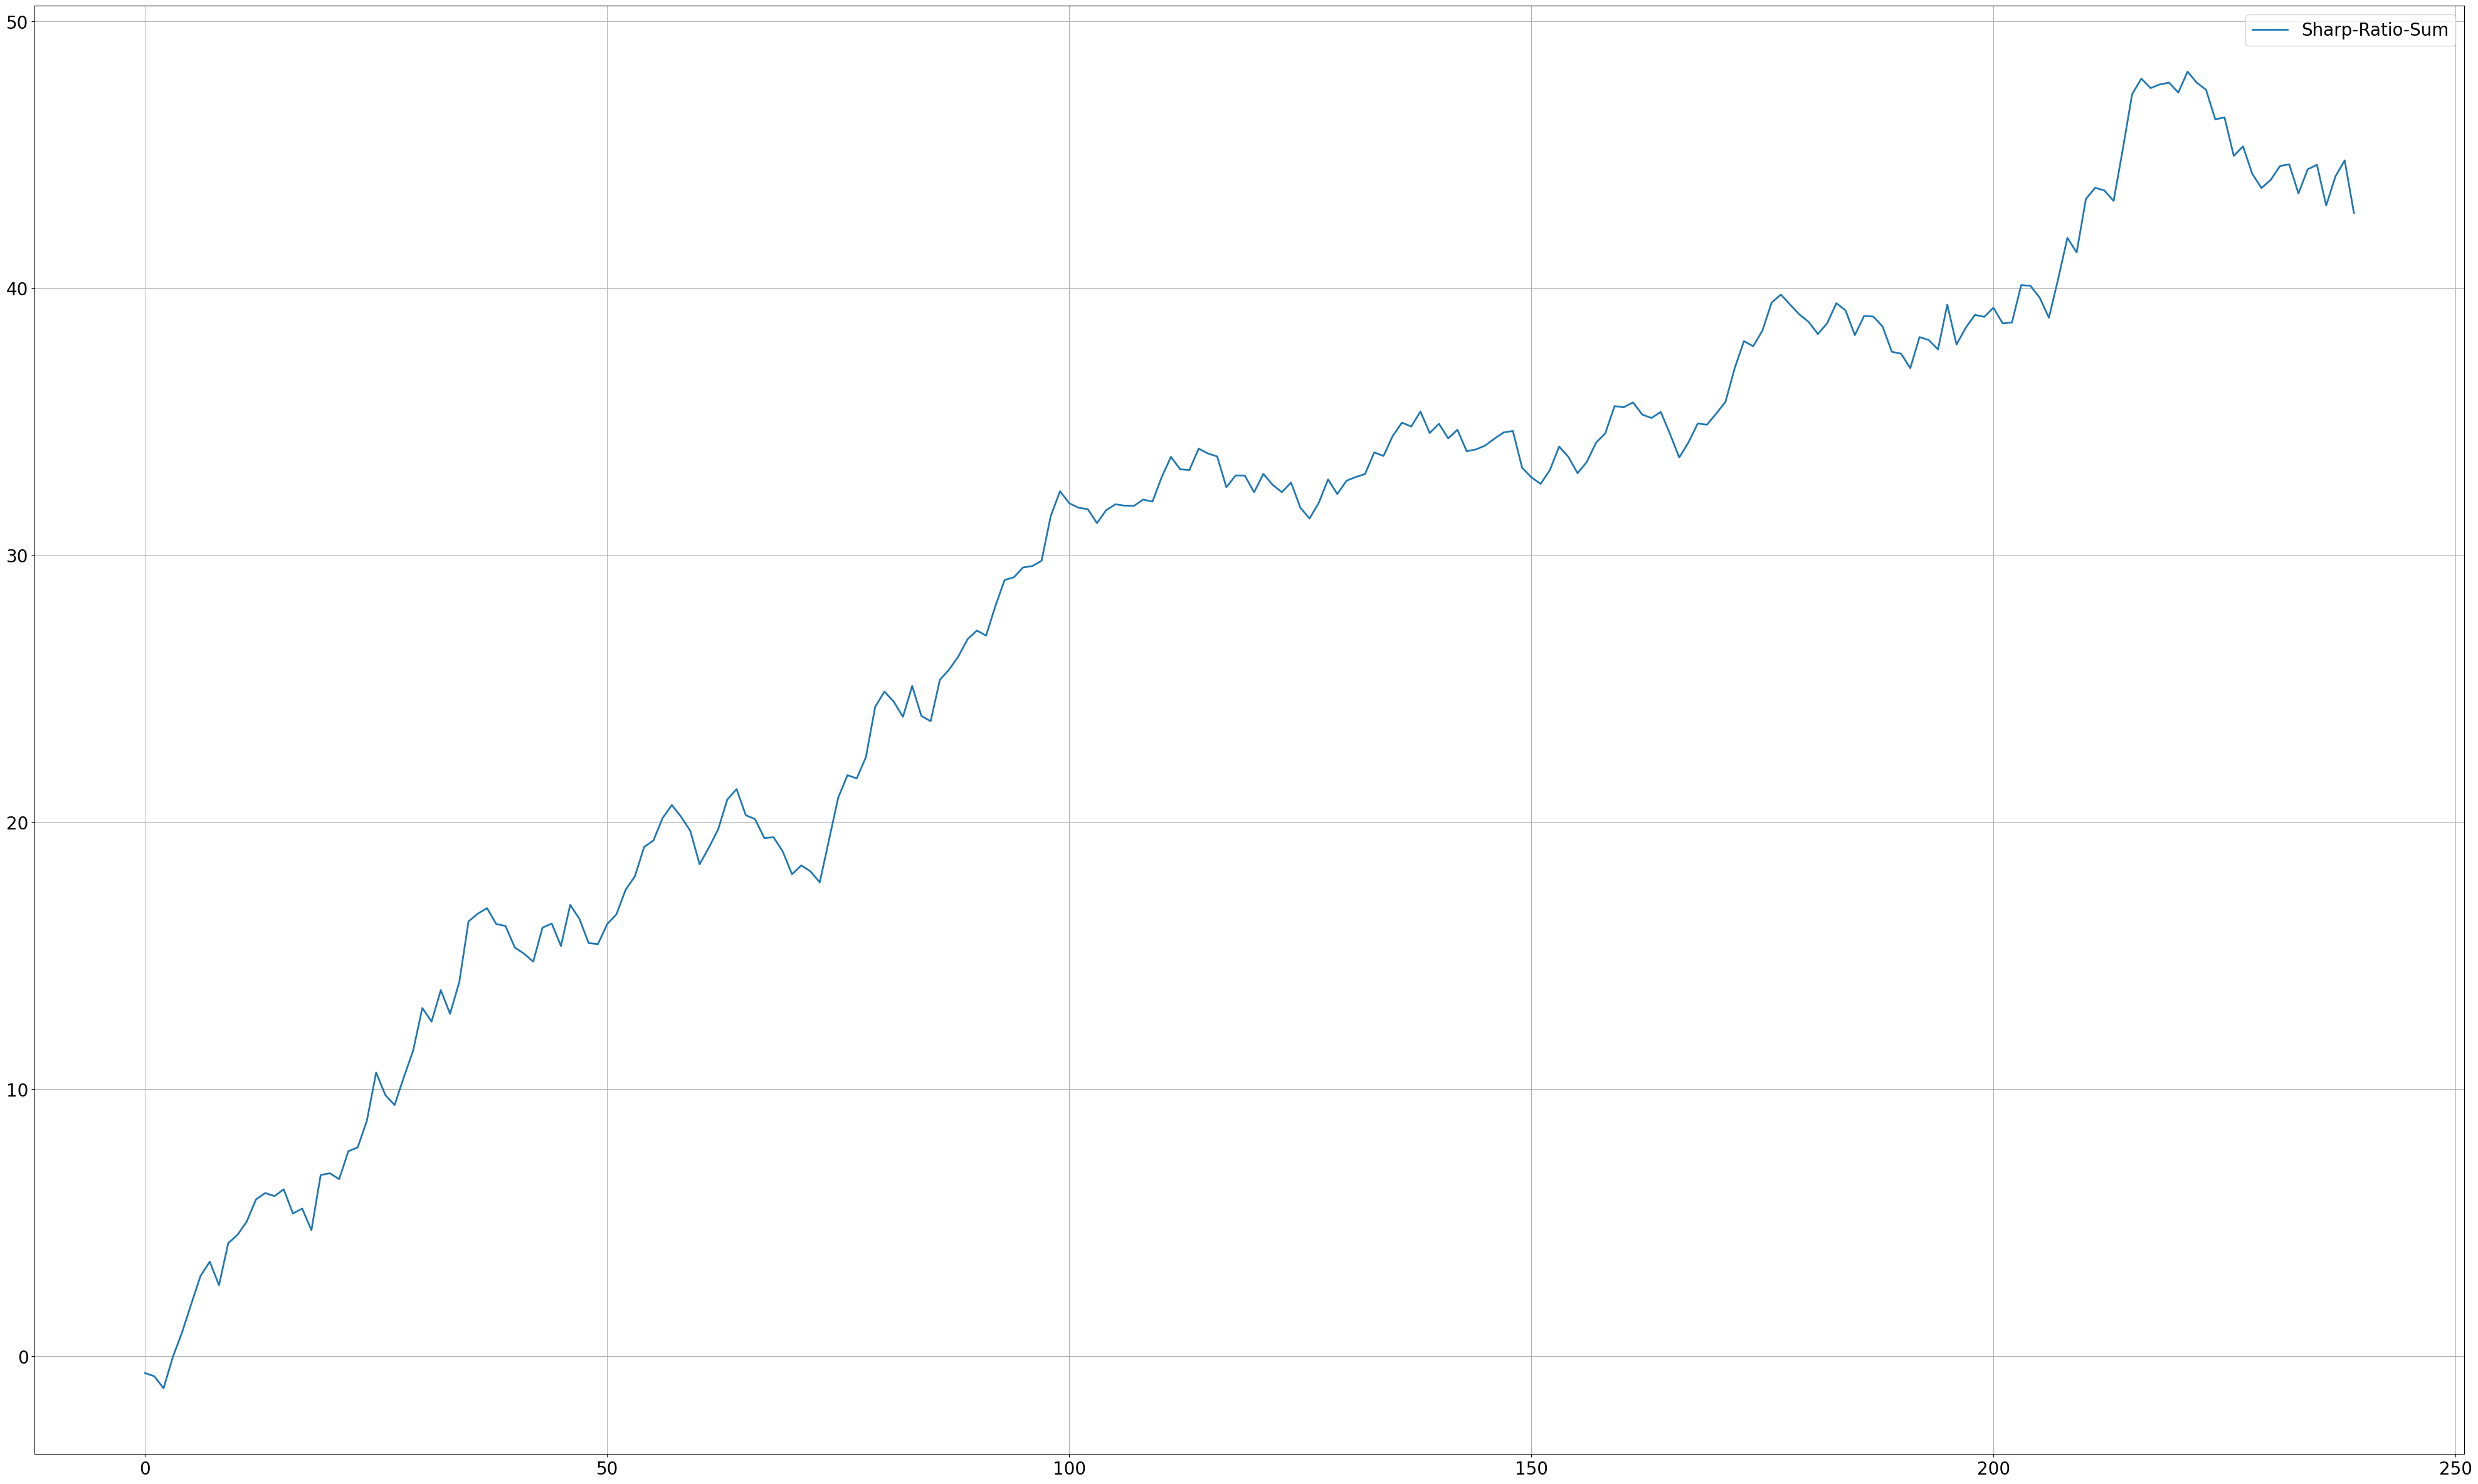

In [9]:
measure_name = 'asset-amount'

df_mpt_a = df_mpt_a.sort_values(by=['eod_date'], ascending=True)
df_mpt_a['yyyymm'] = df_mpt_a['eod_date']
df_mpt_a['yyyymm'] = df_mpt_a['yyyymm'].astype(str)
df_mpt_a['yyyymm'] = df_mpt_a['yyyymm'].str[0:6]

df_mpt_a['yesterday'] = df_mpt_a[measure_name].shift(1)
df_mpt_a = df_mpt_a.tail(df_mpt_a.shape[0] - 1)
df_mpt_a['profit'] = (df_mpt_a[measure_name] - df_mpt_a['yesterday']) / df_mpt_a['yesterday']

list_mpt_a_sharp = list()
for yyyymm in df_mpt_a['yyyymm'].unique():
    df_mpt_a_part = df_mpt_a[df_mpt_a['yyyymm'] == yyyymm]
    price_tail = float(df_mpt_a_part.tail(1)[measure_name].tolist()[0])
    price_head = float(df_mpt_a_part.head(1)[measure_name].tolist()[0])
    list_mpt_a_sharp.append({
        'YYYYMM': int(yyyymm),
        'PRICE_FIRST': price_head,
        'PRICE_LAST': price_tail,
        'PROFIT': (price_tail - price_head) / price_head,
        # 'PROFIT': numpy.mean(df_kospi_part['profit']) * 30,
        'VARIANCE': numpy.std(df_mpt_a_part['profit']) * numpy.sqrt(30),
    })
df_mpt_a_sharp = pandas.DataFrame(list_mpt_a_sharp)
df_mpt_a_sharp = df_mpt_a_sharp[df_mpt_a_sharp['YYYYMM'] >= 200301]
df_mpt_a_sharp['Sharp-Ratio'] = df_mpt_a_sharp['PROFIT'] / df_mpt_a_sharp['VARIANCE']
df_mpt_a_sharp['Sharp-Ratio-Sum'] = df_mpt_a_sharp['Sharp-Ratio'].cumsum()
display(df_mpt_a_sharp)
df_mpt_a_sharp.to_csv('data-0303-mpt-a.csv', index=None)
df_mpt_a_sharp_plot = df_mpt_a_sharp[['Sharp-Ratio-Sum']]
df_mpt_a_sharp_plot.plot()

df_mpt_a_result = df_mpt_a_sharp[['YYYYMM', 'Sharp-Ratio-Sum']]
df_mpt_a_result = df_mpt_a_result.set_index(['YYYYMM'])
df_mpt_a_result.columns = ['MPT-A']
df_all = df_all.join(df_mpt_a_result, how='left')

<Axes: xlabel='ts'>

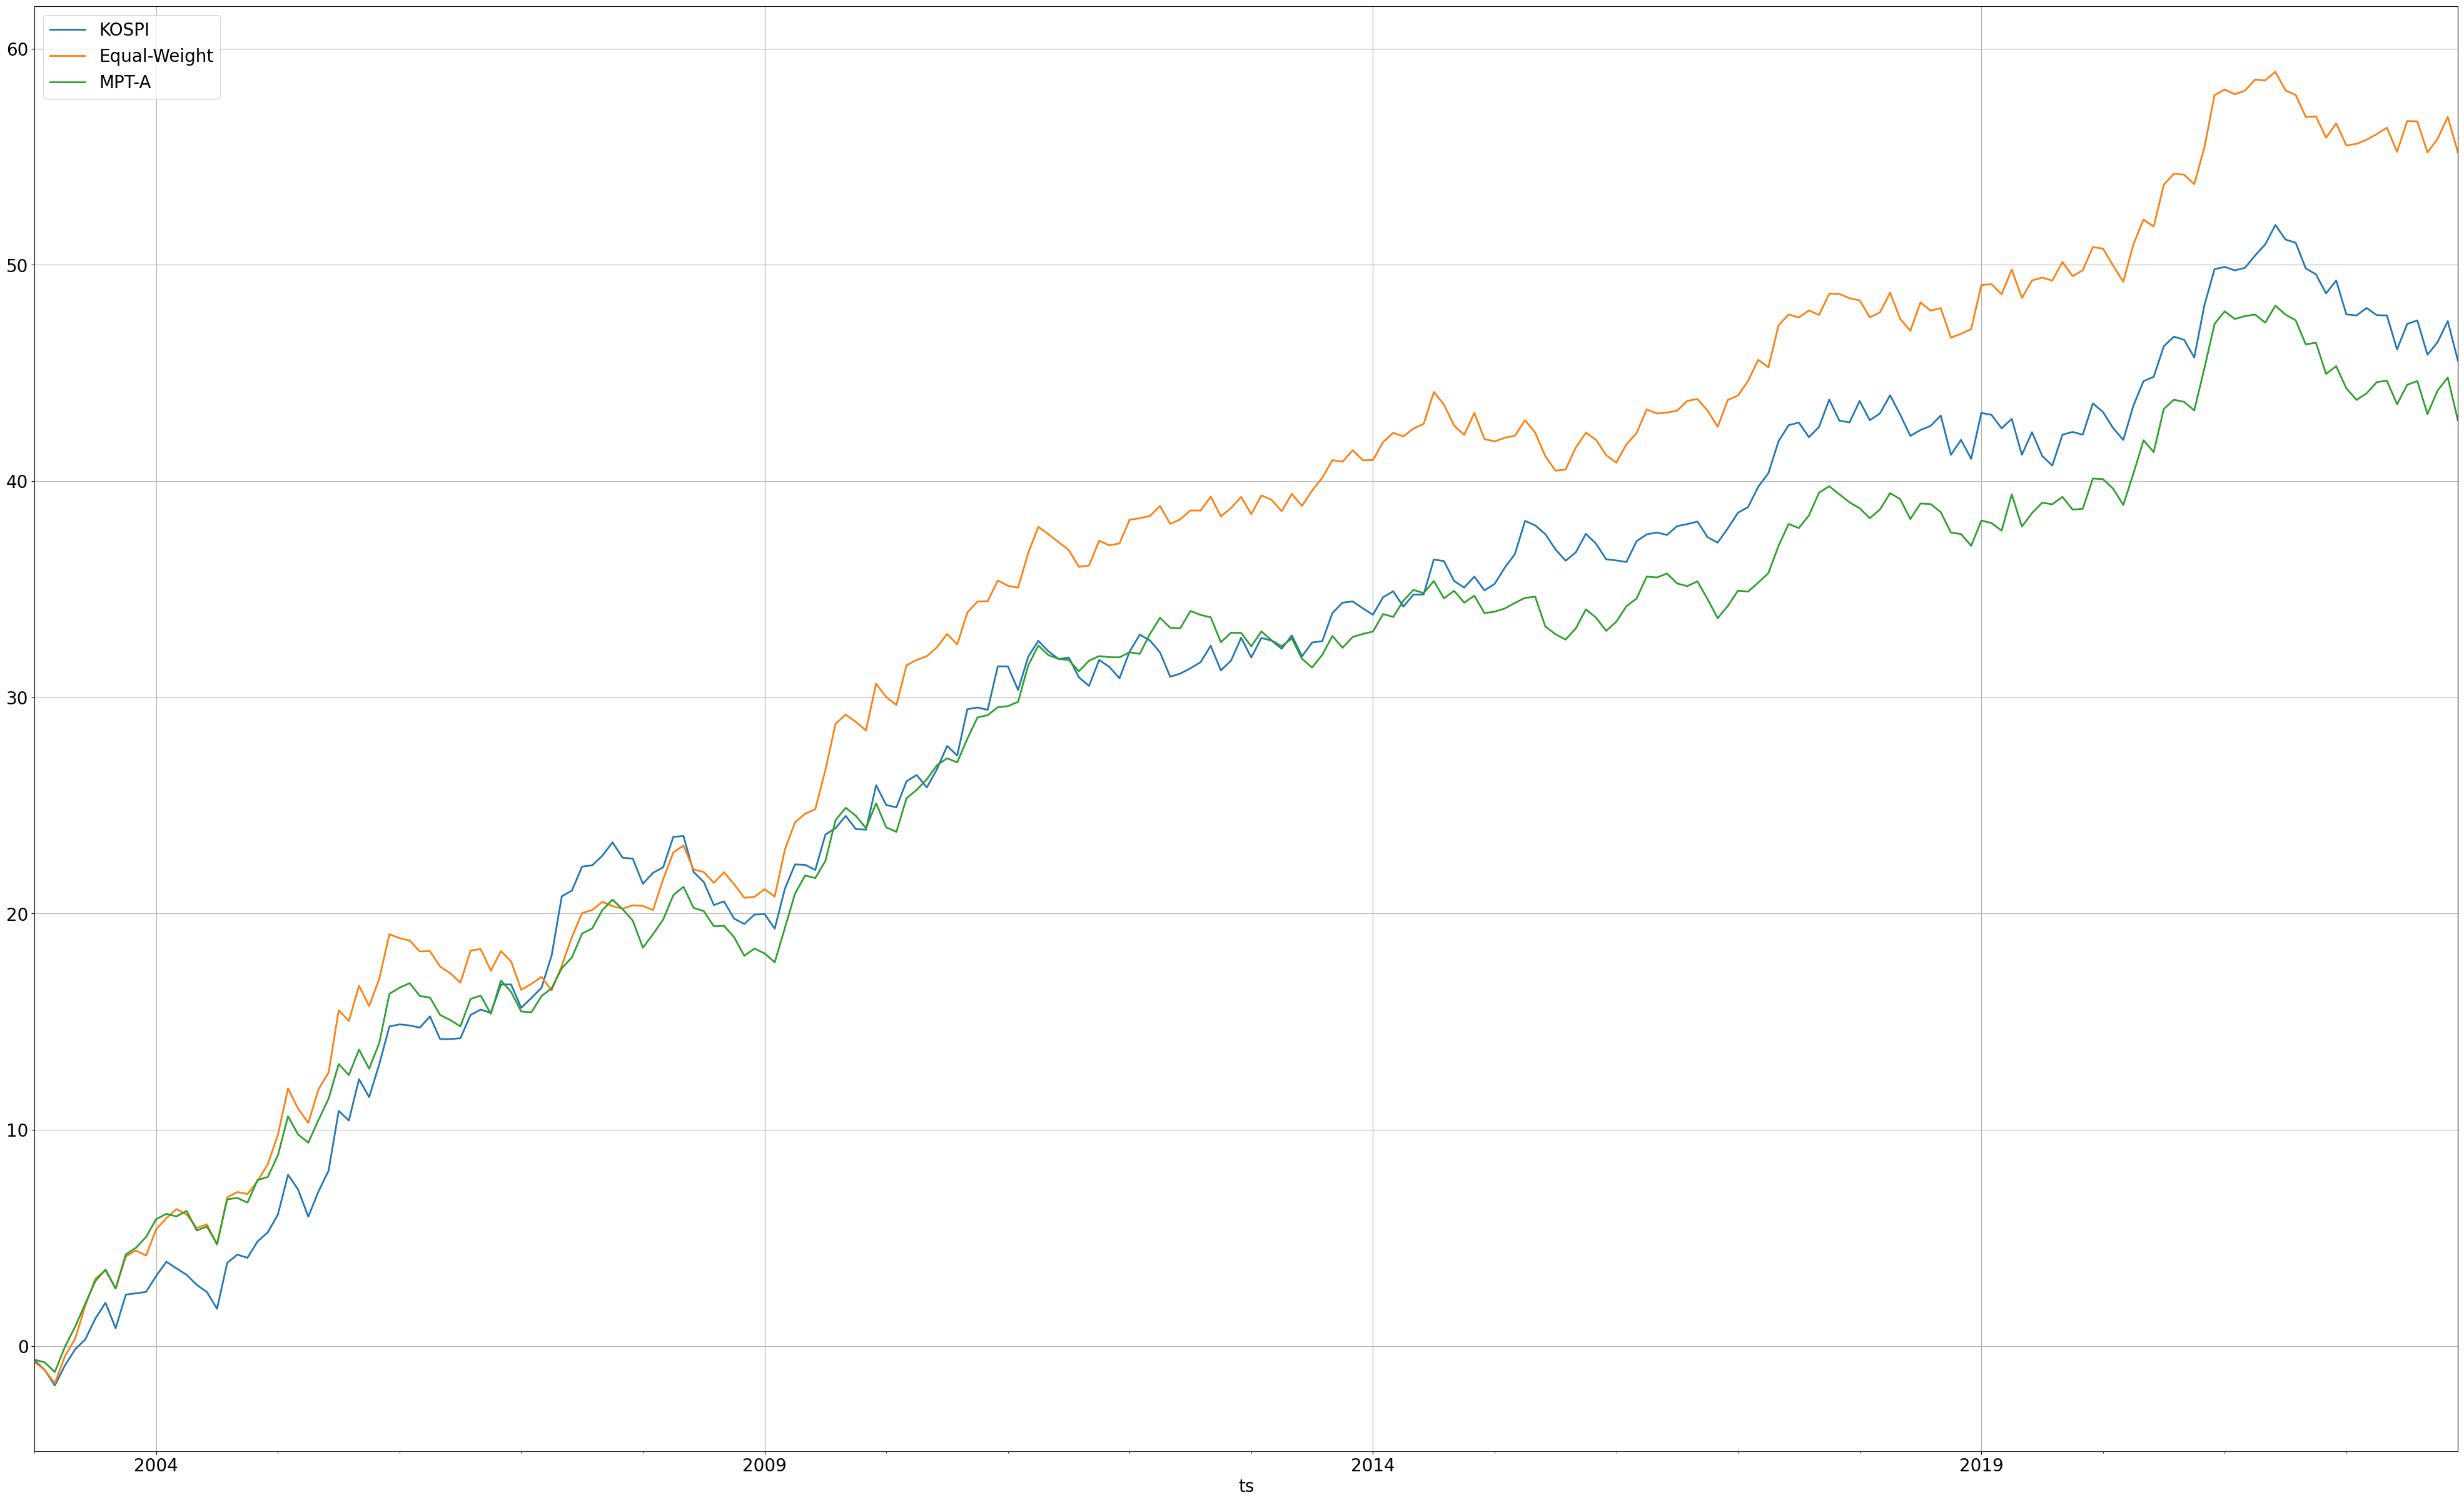

In [10]:
df_all_plot = df_all.copy()
df_all_plot['ts'] = pandas.to_datetime(df_all.index, format='%Y%m')
df_all_plot = df_all_plot.set_index(['ts'])
df_all_plot.plot()

# 5. Mean Variance Portfolio Sharp Ratio

In [11]:
def asset_allocation(p_args):
    l_dict_price = p_args['prices']
    l_dict_asset_count = p_args['asset_count']
    l_dict_asset_ratio = p_args['asset_ratio']
    l_total_amount = p_args['asset_amount']
    l_asset_code = p_args['asset_list']
    l_balance_code = p_args['balance_code']
    l_std_date = p_args['std_date']

    sum_to_modify_amount = 0

    dict_asset_new = dict()
    dict_need_to_modify = dict()
    for equity_code in l_asset_code:
        asset_new = (l_total_amount + l_dict_asset_count[l_balance_code]) * l_dict_asset_ratio[equity_code]
        asset_previous = l_dict_asset_count[equity_code]
        try:
            dict_asset_new[equity_code] = int(asset_new / l_dict_price[equity_code])
        except:
            import sys
            print(l_std_date, equity_code, l_dict_price[equity_code])
            sys.exit(1)
        dict_need_to_modify[equity_code] = int(asset_new / l_dict_price[equity_code]) - asset_previous
        sum_to_modify_amount += dict_need_to_modify[equity_code] * l_dict_price[equity_code]

    # 조정 대상 금액이 잔액보다 크면, (잔액 + sum(보유수량*시가)) 규모에서 조정
    if sum_to_modify_amount > l_dict_asset_count[l_balance_code]:
        # print('Re-ALLOCATION')
        total_asset_new = l_dict_asset_count[l_balance_code]
        for equity_code in l_asset_code:
            total_asset_new += l_dict_asset_count[equity_code] * l_dict_price[equity_code]

        sum_to_modify_amount = 0
        for equity_code in l_asset_code:
            asset_new = total_asset_new * l_dict_asset_ratio[equity_code]
            asset_previous = l_dict_asset_count[equity_code]
            dict_asset_new[equity_code] = int(asset_new / l_dict_price[equity_code])
            dict_need_to_modify[equity_code] = int(asset_new / l_dict_price[equity_code]) - asset_previous
            sum_to_modify_amount += dict_need_to_modify[equity_code] * l_dict_price[equity_code]

    for equity_code in l_asset_code:
        dict_asset_new[equity_code] = l_dict_asset_count[equity_code] + dict_need_to_modify[equity_code]
    dict_asset_new[l_balance_code] = l_dict_asset_count[l_balance_code] - sum_to_modify_amount

    return dict_asset_new

df_prices = pandas.read_csv('data-0201-base.csv')
df_prices = df_prices.set_index(['기준일자'])

# 종가로 판단해서 수량을 설정하고,
# 시가로 수량을 조정하고,
# 조정 후 수량을 종가로 평가한다.
list_code = [
    'A005930', 'A000660', 'A006400', 'A005380', 'A000270',
    'A005490', 'A012330', 'A015760', 'A033780', 'A003550'
]
balance_code = 'A999999'
invest_amount = 1000000000

# 총 자산금액
asset_amount = 0
# 조정 후 목표 비율: 종목 / 비율
dict_asset_ratio = dict()
# 현재 보유 자산: 종목 / 보유 수량
dict_asset_count = dict()
for equity_code in list_code:
    dict_asset_count[equity_code] = 0
dict_asset_count[balance_code] = invest_amount

df_mpt_b = pandas.read_csv('./data-0202-mpt-B.csv')
dict_cols = dict()
for col_name in df_mpt_b.columns:
    for code in list_code:
        if code in col_name:
            dict_cols[code] = col_name

day_to_start = 20030101
day_to_finish = 20221229
asset_amount = 0
loop_count = 0
prev_A005930_price = 0
prev_A000660_price = 0
prev_A006400_price = 0
prev_A005380_price = 0
prev_A000270_price = 0
prev_A005490_price = 0
prev_A012330_price = 0
prev_A015760_price = 0
prev_A033780_price = 0
prev_A003550_price = 0

list_mpt_b = list()
for eod_date, row in df_prices.iterrows():
    if eod_date < day_to_start:
        continue
    if eod_date > day_to_finish:
        continue

    df_mpt_b_part = df_mpt_b[df_mpt_b['기준일자'] == eod_date]
    for equity_code in list_code:
        dict_asset_ratio[equity_code] = df_mpt_b_part[dict_cols[equity_code]].tolist()[0]

    # 판단을 위한 가격
    df_asset = df_prices[df_prices.index <= eod_date]
    df_asset_today = df_asset.tail(1)
    df_asset_yesterday = df_asset.tail(2).head(1)

    dict_price_curr_C = dict()
    dict_price_curr_C['A005930'] = float(df_asset_today['A005930-삼성전자-종가'].tolist()[0])
    dict_price_curr_C['A000660'] = float(df_asset_today['A000660-SK하이닉스-종가'].tolist()[0])
    dict_price_curr_C['A006400'] = float(df_asset_today['A006400-삼성SDI-종가'].tolist()[0])
    dict_price_curr_C['A005380'] = float(df_asset_today['A005380-현대차-종가'].tolist()[0])
    dict_price_curr_C['A000270'] = float(df_asset_today['A000270-기아-종가'].tolist()[0])
    dict_price_curr_C['A005490'] = float(df_asset_today['A005490-POSCO홀딩스-종가'].tolist()[0])
    dict_price_curr_C['A012330'] = float(df_asset_today['A012330-현대모비스-종가'].tolist()[0])
    dict_price_curr_C['A015760'] = float(df_asset_today['A015760-한국전력-종가'].tolist()[0])
    dict_price_curr_C['A033780'] = float(df_asset_today['A033780-KT&G-종가'].tolist()[0])
    dict_price_curr_C['A003550'] = float(df_asset_today['A003550-LG-종가'].tolist()[0])

    dict_price_curr_O = dict()
    dict_price_curr_O['A005930'] = float(df_asset_today['A005930-삼성전자-시가'].tolist()[0])
    dict_price_curr_O['A000660'] = float(df_asset_today['A000660-SK하이닉스-시가'].tolist()[0])
    dict_price_curr_O['A006400'] = float(df_asset_today['A006400-삼성SDI-시가'].tolist()[0])
    dict_price_curr_O['A005380'] = float(df_asset_today['A005380-현대차-시가'].tolist()[0])
    dict_price_curr_O['A000270'] = float(df_asset_today['A000270-기아-시가'].tolist()[0])
    dict_price_curr_O['A005490'] = float(df_asset_today['A005490-POSCO홀딩스-시가'].tolist()[0])
    dict_price_curr_O['A012330'] = float(df_asset_today['A012330-현대모비스-시가'].tolist()[0])
    dict_price_curr_O['A015760'] = float(df_asset_today['A015760-한국전력-시가'].tolist()[0])
    dict_price_curr_O['A033780'] = float(df_asset_today['A033780-KT&G-시가'].tolist()[0])
    dict_price_curr_O['A003550'] = float(df_asset_today['A003550-LG-시가'].tolist()[0])

    if dict_price_curr_O['A005930'] == 0:
        dict_price_curr_O['A005930'] = prev_A005930_price
    else:
        prev_A005930_price = float(df_asset_today['A005930-삼성전자-시가'].tolist()[0])
    if dict_price_curr_O['A000660'] == 0:
        dict_price_curr_O['A000660'] = prev_A000660_price
    else:
        prev_A000660_price = float(df_asset_today['A000660-SK하이닉스-시가'].tolist()[0])
    if dict_price_curr_O['A006400'] == 0:
        dict_price_curr_O['A006400'] = prev_A006400_price
    else:
        prev_A006400_price = float(df_asset_today['A006400-삼성SDI-시가'].tolist()[0])
    if dict_price_curr_O['A005380'] == 0:
        dict_price_curr_O['A005380'] = prev_A005380_price
    else:
        prev_A005380_price = float(df_asset_today['A005380-현대차-시가'].tolist()[0])
    if dict_price_curr_O['A000270'] == 0:
        dict_price_curr_O['A000270'] = prev_A000270_price
    else:
        prev_A000270_price = float(df_asset_today['A000270-기아-시가'].tolist()[0])
    if dict_price_curr_O['A005490'] == 0:
        dict_price_curr_O['A005490'] = prev_A005490_price
    else:
        prev_A005490_price = float(df_asset_today['A005490-POSCO홀딩스-시가'].tolist()[0])
    if dict_price_curr_O['A012330'] == 0:
        dict_price_curr_O['A012330'] = prev_A012330_price
    else:
        prev_A012330_price = float(df_asset_today['A012330-현대모비스-시가'].tolist()[0])
    if dict_price_curr_O['A015760'] == 0:
        dict_price_curr_O['A015760'] = prev_A015760_price
    else:
        prev_A015760_price = float(df_asset_today['A015760-한국전력-시가'].tolist()[0])
    if dict_price_curr_O['A033780'] == 0:
        dict_price_curr_O['A033780'] = prev_A033780_price
    else:
        prev_A033780_price = float(df_asset_today['A033780-KT&G-시가'].tolist()[0])
    if dict_price_curr_O['A003550'] == 0:
        dict_price_curr_O['A003550'] = prev_A003550_price
    else:
        prev_A003550_price = float(df_asset_today['A003550-LG-시가'].tolist()[0])
    dict_params = dict()
    dict_params['prices'] = dict_price_curr_O

    dict_params['asset_count'] = dict_asset_count
    dict_params['asset_ratio'] = dict_asset_ratio
    dict_params['asset_amount'] = asset_amount
    dict_params['asset_list'] = list_code
    dict_params['balance_code'] = balance_code
    dict_params['std_date'] = eod_date

    asset_amount = 0
    dict_asset_count = asset_allocation(dict_params)
    for equity_code in list_code:
        asset_amount += dict_asset_count[equity_code] * dict_price_curr_C[equity_code]

    '''
    for equity_code in list_code:
        print(
            # 종목코드
            equity_code, '\t',
            # 보유 수량
            dict_asset_count[equity_code], '\t',
            # 당일 시가
            dict_price_curr_O[equity_code], '\t',
            # 당일 종가
            dict_price_curr_C[equity_code], '\t',
            # 당일 평가금액
            dict_asset_count[equity_code] * dict_price_curr_C[equity_code], '\t'
            )
    '''
    # print('Date\t', eod_date, '\tBalance\t', dict_asset_count[balance_code], '\tAsset Amount\t', asset_amount)
    list_mpt_b.append({
        'eod_date': eod_date,
        'asset-amount': asset_amount,
    })

    loop_count += 1
    if loop_count > 10:
        # break
        pass

df_mpt_b = pandas.DataFrame(list_mpt_b)
display(df_mpt_b)

,eod_date,asset-amount
0,20030102,9.937087e+08
1,20030103,9.970419e+08
2,20030106,1.025070e+09
3,20030107,9.944957e+08
4,20030108,1.020983e+09
...,...,...
4942,20221223,8.418520e+09
4943,20221226,8.378057e+09
4944,20221227,8.326454e+09
4945,20221228,8.157436e+09


,YYYYMM,PRICE_FIRST,PRICE_LAST,PROFIT,VARIANCE,Sharp-Ratio,Sharp-Ratio-Sum
0,200301,9.970419e+08,9.658018e+08,-0.031333,0.100673,-0.311231,-0.311231
1,200302,9.757235e+08,9.573315e+08,-0.018850,0.063316,-0.297704,-0.608935
2,200303,9.822170e+08,9.523994e+08,-0.030357,0.078926,-0.384633,-0.993568
3,200304,9.389420e+08,1.048809e+09,0.117011,0.075087,1.558341,0.564773
4,200305,1.041227e+09,1.090579e+09,0.047397,0.064494,0.734908,1.299681
...,...,...,...,...,...,...,...
235,202208,7.909498e+09,8.025325e+09,0.014644,0.038250,0.382850,51.018184
236,202209,7.913769e+09,7.645089e+09,-0.033951,0.037580,-0.903431,50.114753
237,202210,7.731530e+09,8.285238e+09,0.071617,0.051313,1.395673,51.510426
238,202211,8.277714e+09,8.841992e+09,0.068168,0.046211,1.475157,52.985583


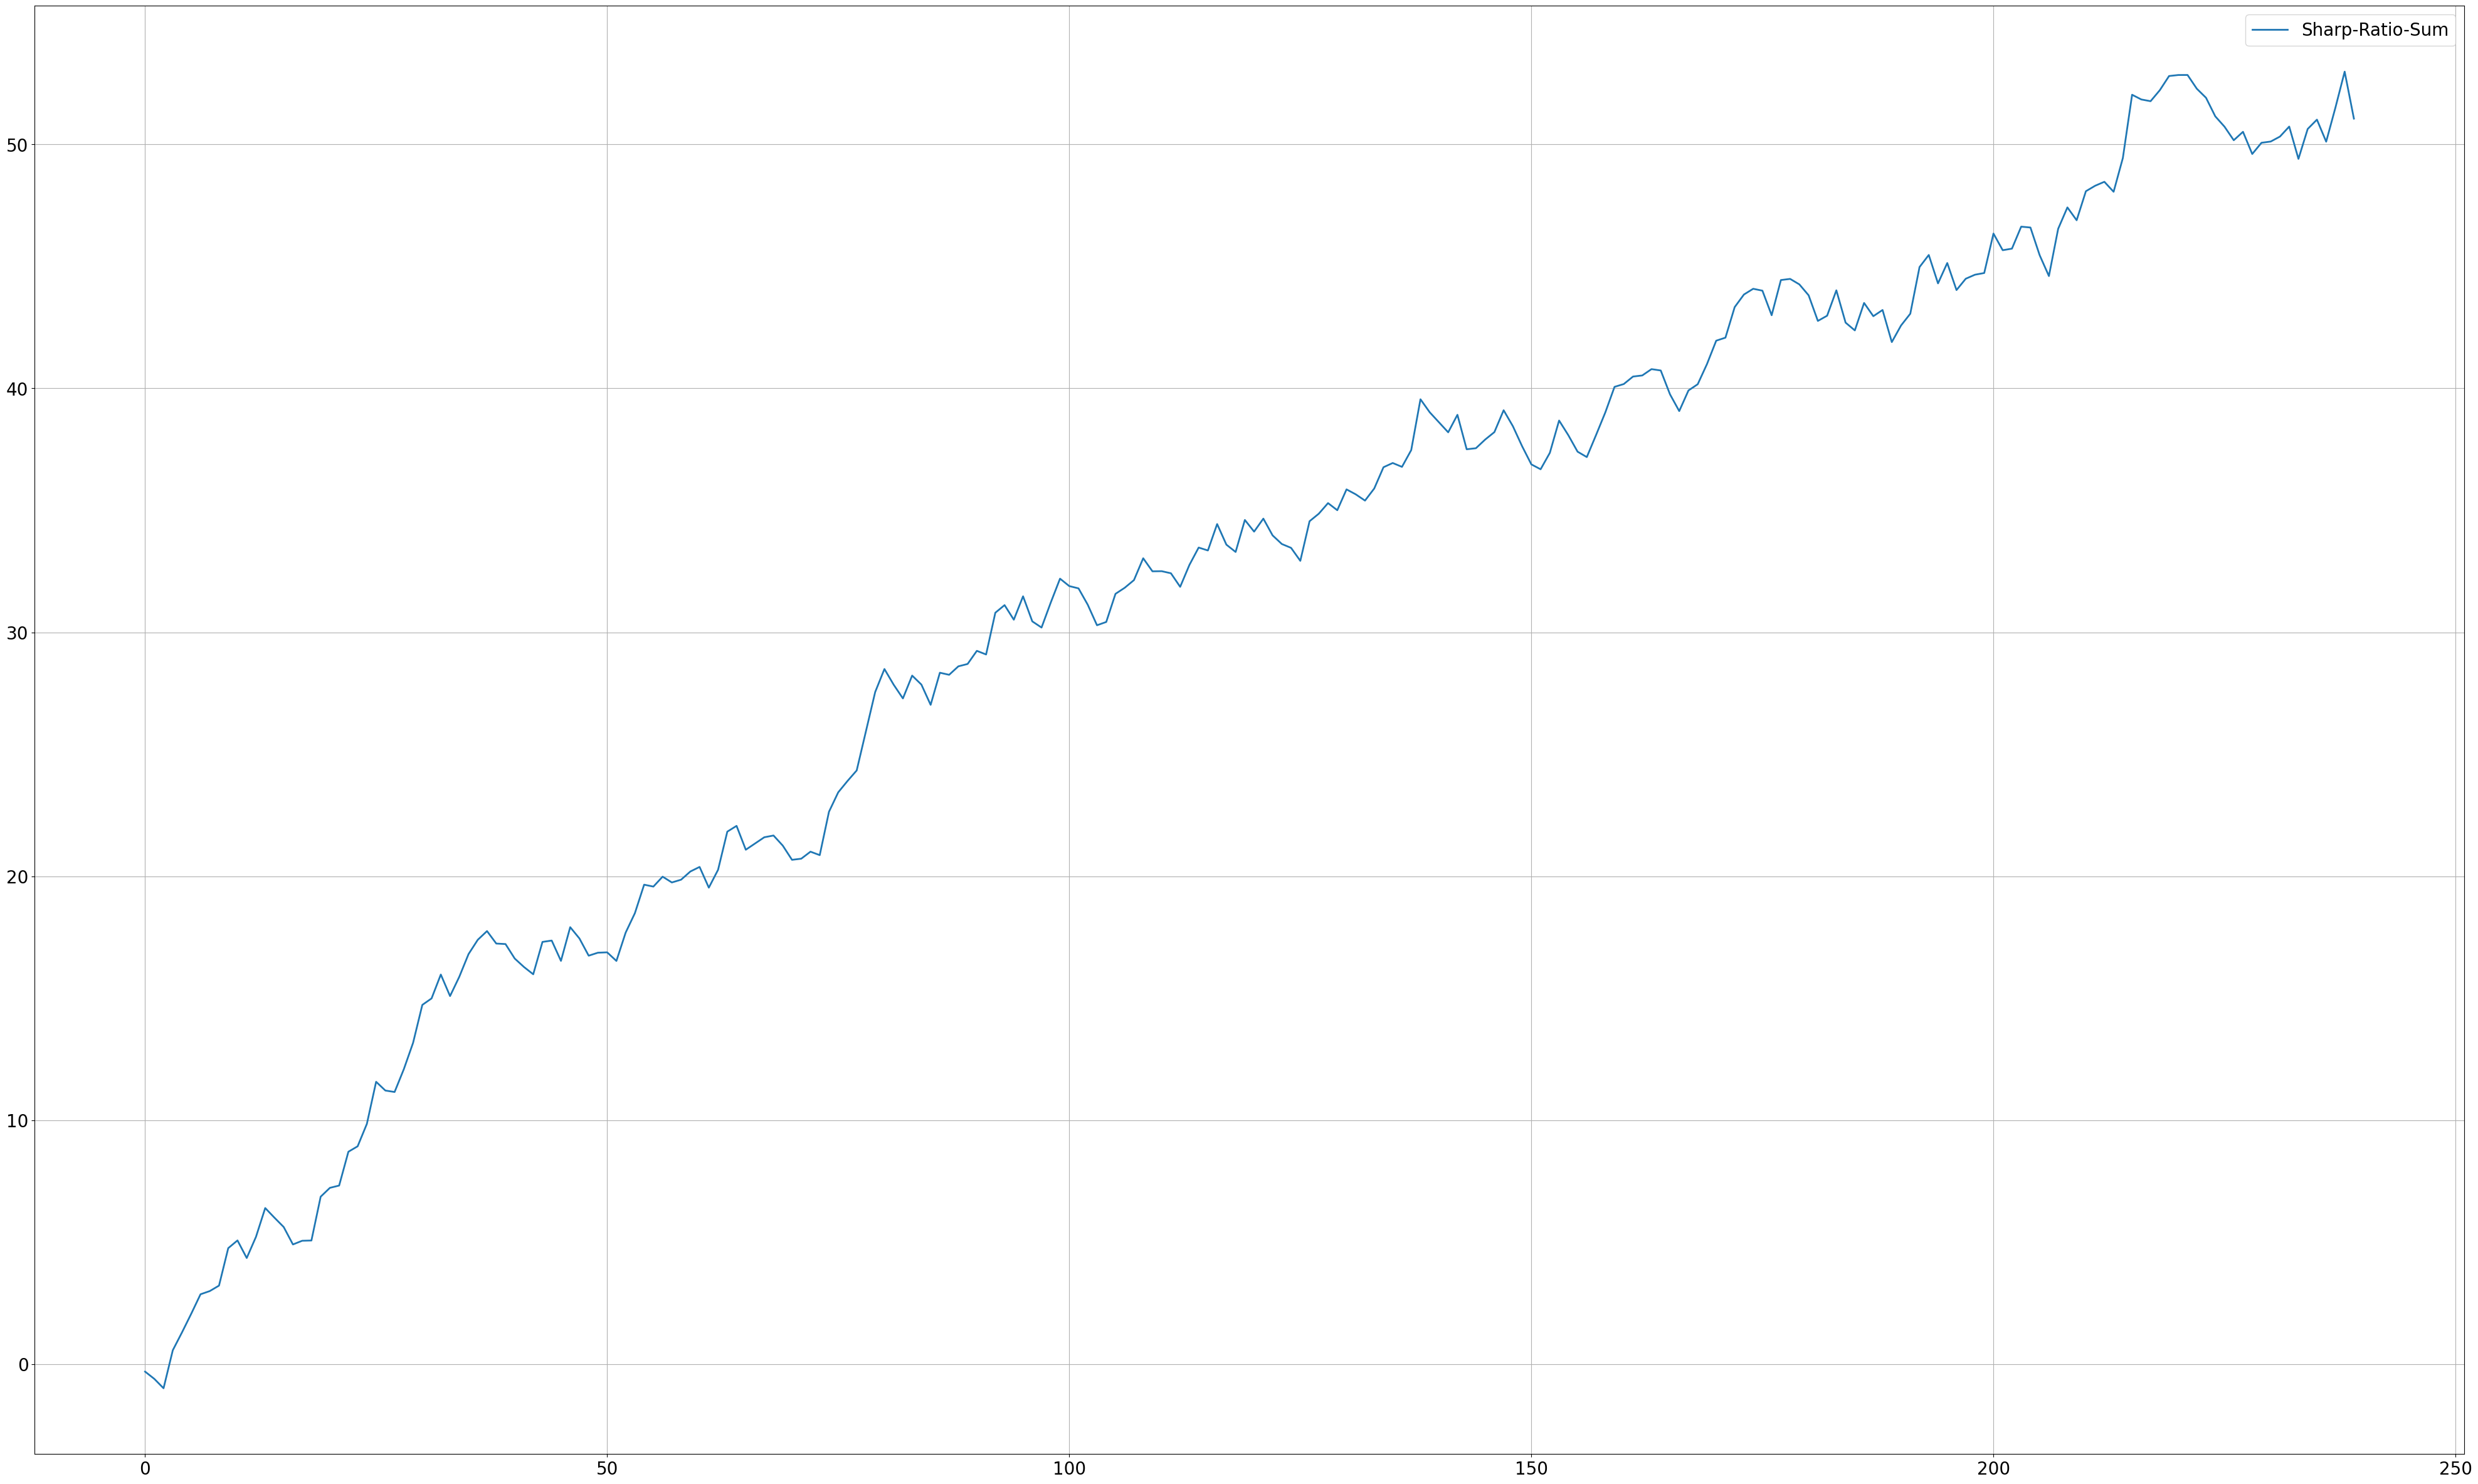

In [12]:
measure_name = 'asset-amount'

df_mpt_b = df_mpt_b.sort_values(by=['eod_date'], ascending=True)
df_mpt_b['yyyymm'] = df_mpt_b['eod_date']
df_mpt_b['yyyymm'] = df_mpt_b['yyyymm'].astype(str)
df_mpt_b['yyyymm'] = df_mpt_b['yyyymm'].str[0:6]

df_mpt_b['yesterday'] = df_mpt_b[measure_name].shift(1)
df_mpt_b = df_mpt_b.tail(df_mpt_b.shape[0] - 1)
df_mpt_b['profit'] = (df_mpt_b[measure_name] - df_mpt_b['yesterday']) / df_mpt_b['yesterday']

list_mpt_b_sharp = list()
for yyyymm in df_mpt_b['yyyymm'].unique():
    df_mpt_b_part = df_mpt_b[df_mpt_b['yyyymm'] == yyyymm]
    price_tail = float(df_mpt_b_part.tail(1)[measure_name].tolist()[0])
    price_head = float(df_mpt_b_part.head(1)[measure_name].tolist()[0])
    list_mpt_b_sharp.append({
        'YYYYMM': int(yyyymm),
        'PRICE_FIRST': price_head,
        'PRICE_LAST': price_tail,
        'PROFIT': (price_tail - price_head) / price_head,
        # 'PROFIT': numpy.mean(df_kospi_part['profit']) * 30,
        'VARIANCE': numpy.std(df_mpt_b_part['profit']) * numpy.sqrt(30),
    })
df_mpt_b_sharp = pandas.DataFrame(list_mpt_b_sharp)
df_mpt_b_sharp = df_mpt_b_sharp[df_mpt_b_sharp['YYYYMM'] >= 200301]
df_mpt_b_sharp['Sharp-Ratio'] = df_mpt_b_sharp['PROFIT'] / df_mpt_b_sharp['VARIANCE']
df_mpt_b_sharp['Sharp-Ratio-Sum'] = df_mpt_b_sharp['Sharp-Ratio'].cumsum()
display(df_mpt_b_sharp)
df_mpt_b_sharp.to_csv('data-0304-mpt-b.csv', index=None)
df_mpt_b_sharp_plot = df_mpt_b_sharp[['Sharp-Ratio-Sum']]
df_mpt_b_sharp_plot.plot()

df_mpt_b_result = df_mpt_b_sharp[['YYYYMM', 'Sharp-Ratio-Sum']]
df_mpt_b_result = df_mpt_b_result.set_index(['YYYYMM'])
df_mpt_b_result.columns = ['MPT-B']
df_all = df_all.join(df_mpt_b_result, how='left')

<Axes: xlabel='ts'>

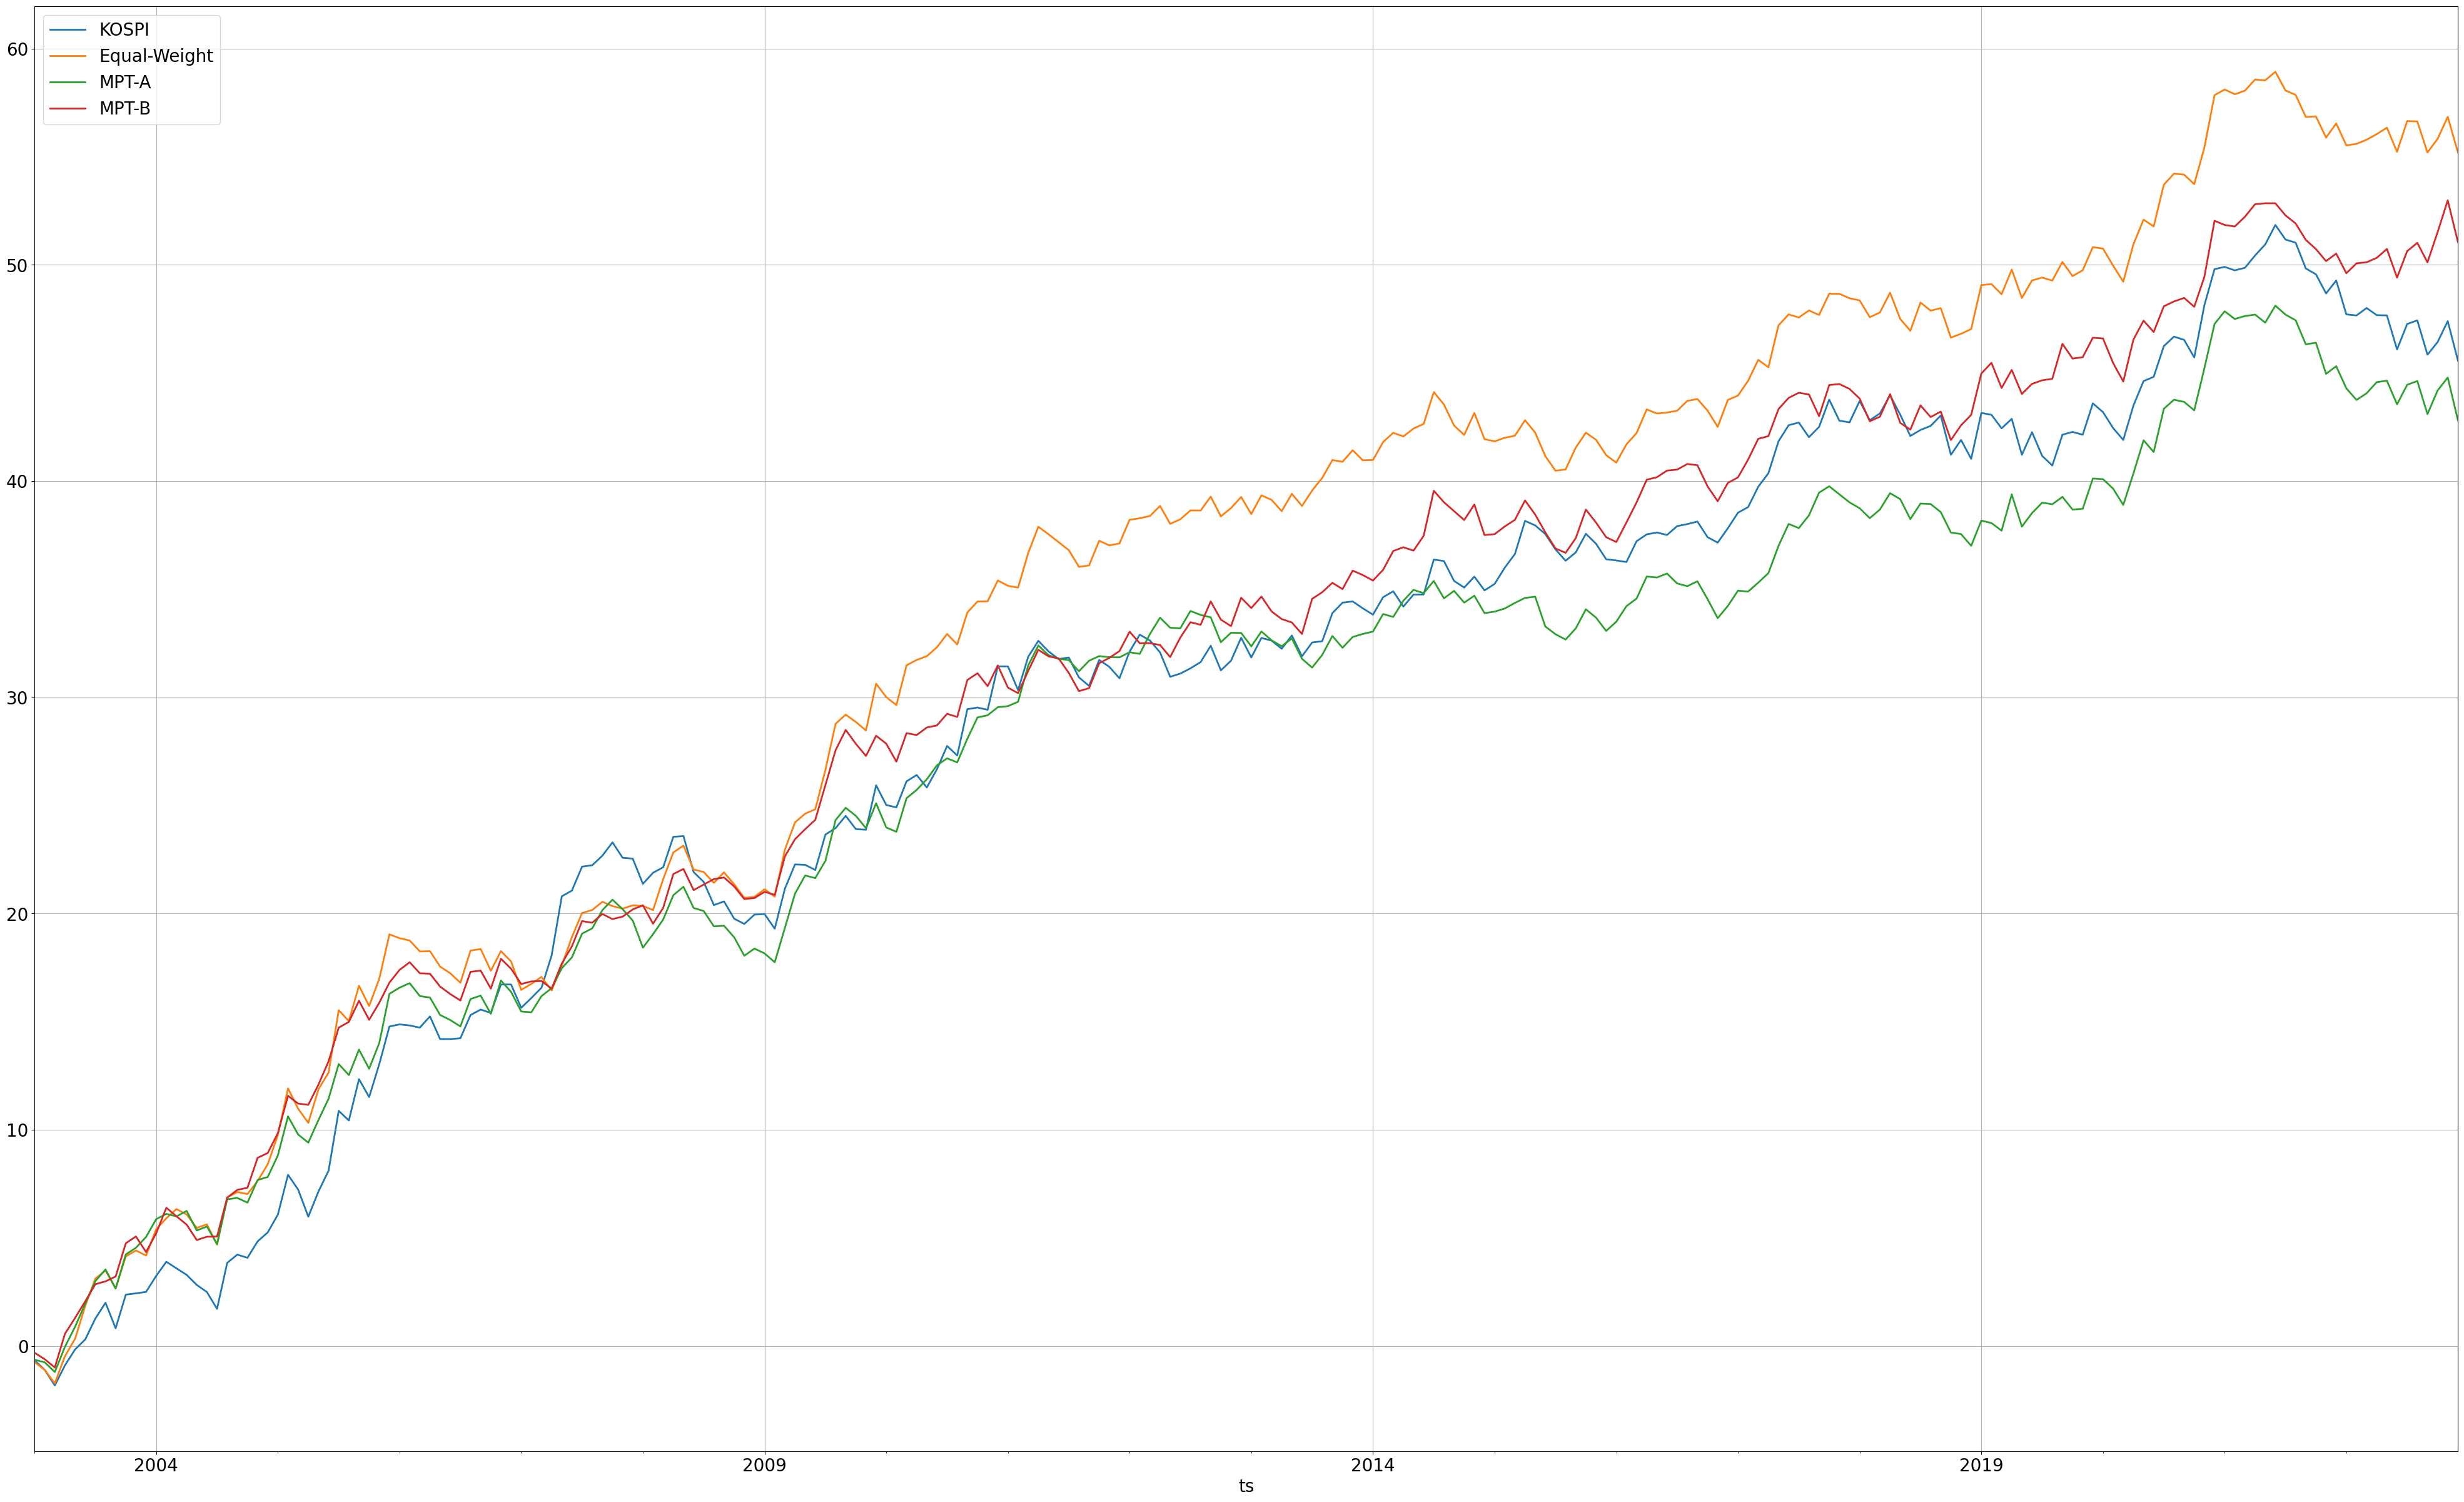

In [13]:
df_all_plot = df_all.copy()
df_all_plot['ts'] = pandas.to_datetime(df_all.index, format='%Y%m')
df_all_plot = df_all_plot.set_index(['ts'])
df_all_plot.plot()

# 6. Risk Parity Portfolio Sharp Ratio

# 7. A2C Portfolio Sharp Ratio

In [14]:
import os
os.system('cat ./data/A2C/*csv > data-0204-a2c.csv')
df_a2c = pandas.read_csv('./data-0204-a2c.csv')
df_a2c = df_a2c[df_a2c['기준일자'] != '기준일자']
display(df_a2c)
df_a2c.to_csv('data-0204-a2c.csv', index=None)

,기준일자,A005930-삼성전자-종가,A000660-SK하이닉스-종가,A006400-삼성SDI-종가,A005380-현대차-종가,A000270-기아-종가,A005490-POSCO홀딩스-종가,A012330-현대모비스-종가,A015760-한국전력-종가,A033780-KT&G-종가,A003550-LG-종가
0,20030102,0.07527641022245543,0.06314239915439251,0.12350945126928299,0.06246482506058637,0.06317843590327324,0.08711166127392803,0.15900720588372994,0.13289482671311517,0.035459715526369645,0.19795506899286672
2,20030103,0.08848726393138914,0.11680692463290802,0.14302597205039463,0.13501561949733004,0.05144945105270602,0.12879476027103157,0.0995304889721069,0.04497779300635789,0.058908271449076934,0.13300345513669887
4,20030106,0.0822256617872835,0.11714014124817491,0.09882631444530496,0.0964271263020898,0.1116812601571274,0.09232325615831374,0.0725485057569473,0.09616855631963825,0.09447810567033832,0.13818107215478187
6,20030107,0.13699451725087242,0.06854514558137383,0.14797898894642916,0.09429171085716774,0.11852367895373886,0.030438149222786575,0.11324650182039682,0.06849834898867299,0.06231276992099882,0.15917018845756276
8,20030108,0.1225099785809198,0.05542007972702562,0.0779797158263062,0.08592260989885443,0.11630248677418482,0.13536283619358108,0.10151914017704486,0.11215950328613025,0.03528681945481715,0.1575368300811358
...,...,...,...,...,...,...,...,...,...,...,...
9884,20221223,0.06357061460234523,0.09730720519158383,0.101262239598041,0.04329594318416281,0.037175138009129936,0.147192090571242,0.16679556445767324,0.18516467256381658,0.11856920249657373,0.03966732932543164
9886,20221226,0.0847921816781884,0.08232430982044373,0.08972697885736519,0.06675488386502042,0.10420132725244172,0.12424229009528834,0.14604861925889856,0.11387628650190754,0.0969829086399844,0.09105021403046173
9888,20221227,0.09357864532237894,0.08996004869694134,0.12354943806339277,0.10743202455244989,0.14041088262553528,0.04463852062836892,0.09271815734546633,0.08512123655509438,0.1284843356378324,0.09410671057253975
9890,20221228,0.07571832973635698,0.02417594790677536,0.16003260161587757,0.04838020003893102,0.12626990350950038,0.09560398143632542,0.10682996186740053,0.15664504765192672,0.07675016411704264,0.12959386211986337


In [15]:
def asset_allocation(p_args):
    l_dict_price = p_args['prices']
    l_dict_asset_count = p_args['asset_count']
    l_dict_asset_ratio = p_args['asset_ratio']
    l_total_amount = p_args['asset_amount']
    l_asset_code = p_args['asset_list']
    l_balance_code = p_args['balance_code']
    l_std_date = p_args['std_date']

    sum_to_modify_amount = 0

    dict_asset_new = dict()
    dict_need_to_modify = dict()
    for equity_code in l_asset_code:
        asset_new = (l_total_amount + l_dict_asset_count[l_balance_code]) * l_dict_asset_ratio[equity_code]
        asset_previous = l_dict_asset_count[equity_code]
        try:
            dict_asset_new[equity_code] = int(asset_new / l_dict_price[equity_code])
        except:
            import sys
            print(l_std_date, equity_code, l_dict_price[equity_code])
            sys.exit(1)
        dict_need_to_modify[equity_code] = int(asset_new / l_dict_price[equity_code]) - asset_previous
        sum_to_modify_amount += dict_need_to_modify[equity_code] * l_dict_price[equity_code]

    # 조정 대상 금액이 잔액보다 크면, (잔액 + sum(보유수량*시가)) 규모에서 조정
    if sum_to_modify_amount > l_dict_asset_count[l_balance_code]:
        # print('Re-ALLOCATION')
        total_asset_new = l_dict_asset_count[l_balance_code]
        for equity_code in l_asset_code:
            total_asset_new += l_dict_asset_count[equity_code] * l_dict_price[equity_code]

        sum_to_modify_amount = 0
        for equity_code in l_asset_code:
            asset_new = total_asset_new * l_dict_asset_ratio[equity_code]
            asset_previous = l_dict_asset_count[equity_code]
            dict_asset_new[equity_code] = int(asset_new / l_dict_price[equity_code])
            dict_need_to_modify[equity_code] = int(asset_new / l_dict_price[equity_code]) - asset_previous
            sum_to_modify_amount += dict_need_to_modify[equity_code] * l_dict_price[equity_code]

    for equity_code in l_asset_code:
        dict_asset_new[equity_code] = l_dict_asset_count[equity_code] + dict_need_to_modify[equity_code]
    dict_asset_new[l_balance_code] = l_dict_asset_count[l_balance_code] - sum_to_modify_amount

    return dict_asset_new

df_prices = pandas.read_csv('data-0201-base.csv')
df_prices = df_prices.set_index(['기준일자'])

# 종가로 판단해서 수량을 설정하고,
# 시가로 수량을 조정하고,
# 조정 후 수량을 종가로 평가한다.
list_code = [
    'A005930', 'A000660', 'A006400', 'A005380', 'A000270',
    'A005490', 'A012330', 'A015760', 'A033780', 'A003550'
]
balance_code = 'A999999'
invest_amount = 1000000000

# 총 자산금액
asset_amount = 0
# 조정 후 목표 비율: 종목 / 비율
dict_asset_ratio = dict()
# 현재 보유 자산: 종목 / 보유 수량
dict_asset_count = dict()
for equity_code in list_code:
    dict_asset_count[equity_code] = 0
dict_asset_count[balance_code] = invest_amount

df_a2c = pandas.read_csv('./data-0204-a2c.csv')
dict_cols = dict()
for col_name in df_a2c.columns:
    for code in list_code:
        if code in col_name:
            dict_cols[code] = col_name

day_to_start = 20030101
day_to_finish = 20221229
asset_amount = 0
loop_count = 0
prev_A005930_price = 0
prev_A000660_price = 0
prev_A006400_price = 0
prev_A005380_price = 0
prev_A000270_price = 0
prev_A005490_price = 0
prev_A012330_price = 0
prev_A015760_price = 0
prev_A033780_price = 0
prev_A003550_price = 0

list_a2c = list()
for eod_date, row in df_prices.iterrows():
    if eod_date < day_to_start:
        continue
    if eod_date > day_to_finish:
        continue

    df_a2c_part = df_a2c[df_a2c['기준일자'] == eod_date]
    for equity_code in list_code:
        dict_asset_ratio[equity_code] = df_a2c_part[dict_cols[equity_code]].tolist()[0]

    # 판단을 위한 가격
    df_asset = df_prices[df_prices.index <= eod_date]
    df_asset_today = df_asset.tail(1)
    df_asset_yesterday = df_asset.tail(2).head(1)

    dict_price_curr_C = dict()
    dict_price_curr_C['A005930'] = float(df_asset_today['A005930-삼성전자-종가'].tolist()[0])
    dict_price_curr_C['A000660'] = float(df_asset_today['A000660-SK하이닉스-종가'].tolist()[0])
    dict_price_curr_C['A006400'] = float(df_asset_today['A006400-삼성SDI-종가'].tolist()[0])
    dict_price_curr_C['A005380'] = float(df_asset_today['A005380-현대차-종가'].tolist()[0])
    dict_price_curr_C['A000270'] = float(df_asset_today['A000270-기아-종가'].tolist()[0])
    dict_price_curr_C['A005490'] = float(df_asset_today['A005490-POSCO홀딩스-종가'].tolist()[0])
    dict_price_curr_C['A012330'] = float(df_asset_today['A012330-현대모비스-종가'].tolist()[0])
    dict_price_curr_C['A015760'] = float(df_asset_today['A015760-한국전력-종가'].tolist()[0])
    dict_price_curr_C['A033780'] = float(df_asset_today['A033780-KT&G-종가'].tolist()[0])
    dict_price_curr_C['A003550'] = float(df_asset_today['A003550-LG-종가'].tolist()[0])

    dict_price_curr_O = dict()
    dict_price_curr_O['A005930'] = float(df_asset_today['A005930-삼성전자-시가'].tolist()[0])
    dict_price_curr_O['A000660'] = float(df_asset_today['A000660-SK하이닉스-시가'].tolist()[0])
    dict_price_curr_O['A006400'] = float(df_asset_today['A006400-삼성SDI-시가'].tolist()[0])
    dict_price_curr_O['A005380'] = float(df_asset_today['A005380-현대차-시가'].tolist()[0])
    dict_price_curr_O['A000270'] = float(df_asset_today['A000270-기아-시가'].tolist()[0])
    dict_price_curr_O['A005490'] = float(df_asset_today['A005490-POSCO홀딩스-시가'].tolist()[0])
    dict_price_curr_O['A012330'] = float(df_asset_today['A012330-현대모비스-시가'].tolist()[0])
    dict_price_curr_O['A015760'] = float(df_asset_today['A015760-한국전력-시가'].tolist()[0])
    dict_price_curr_O['A033780'] = float(df_asset_today['A033780-KT&G-시가'].tolist()[0])
    dict_price_curr_O['A003550'] = float(df_asset_today['A003550-LG-시가'].tolist()[0])

    if dict_price_curr_O['A005930'] == 0:
        dict_price_curr_O['A005930'] = prev_A005930_price
    else:
        prev_A005930_price = float(df_asset_today['A005930-삼성전자-시가'].tolist()[0])
    if dict_price_curr_O['A000660'] == 0:
        dict_price_curr_O['A000660'] = prev_A000660_price
    else:
        prev_A000660_price = float(df_asset_today['A000660-SK하이닉스-시가'].tolist()[0])
    if dict_price_curr_O['A006400'] == 0:
        dict_price_curr_O['A006400'] = prev_A006400_price
    else:
        prev_A006400_price = float(df_asset_today['A006400-삼성SDI-시가'].tolist()[0])
    if dict_price_curr_O['A005380'] == 0:
        dict_price_curr_O['A005380'] = prev_A005380_price
    else:
        prev_A005380_price = float(df_asset_today['A005380-현대차-시가'].tolist()[0])
    if dict_price_curr_O['A000270'] == 0:
        dict_price_curr_O['A000270'] = prev_A000270_price
    else:
        prev_A000270_price = float(df_asset_today['A000270-기아-시가'].tolist()[0])
    if dict_price_curr_O['A005490'] == 0:
        dict_price_curr_O['A005490'] = prev_A005490_price
    else:
        prev_A005490_price = float(df_asset_today['A005490-POSCO홀딩스-시가'].tolist()[0])
    if dict_price_curr_O['A012330'] == 0:
        dict_price_curr_O['A012330'] = prev_A012330_price
    else:
        prev_A012330_price = float(df_asset_today['A012330-현대모비스-시가'].tolist()[0])
    if dict_price_curr_O['A015760'] == 0:
        dict_price_curr_O['A015760'] = prev_A015760_price
    else:
        prev_A015760_price = float(df_asset_today['A015760-한국전력-시가'].tolist()[0])
    if dict_price_curr_O['A033780'] == 0:
        dict_price_curr_O['A033780'] = prev_A033780_price
    else:
        prev_A033780_price = float(df_asset_today['A033780-KT&G-시가'].tolist()[0])
    if dict_price_curr_O['A003550'] == 0:
        dict_price_curr_O['A003550'] = prev_A003550_price
    else:
        prev_A003550_price = float(df_asset_today['A003550-LG-시가'].tolist()[0])
    dict_params = dict()
    dict_params['prices'] = dict_price_curr_O

    dict_params['asset_count'] = dict_asset_count
    dict_params['asset_ratio'] = dict_asset_ratio
    dict_params['asset_amount'] = asset_amount
    dict_params['asset_list'] = list_code
    dict_params['balance_code'] = balance_code
    dict_params['std_date'] = eod_date

    asset_amount = 0
    dict_asset_count = asset_allocation(dict_params)
    for equity_code in list_code:
        asset_amount += dict_asset_count[equity_code] * dict_price_curr_C[equity_code]

    '''
    for equity_code in list_code:
        print(
            # 종목코드
            equity_code, '\t',
            # 보유 수량
            dict_asset_count[equity_code], '\t',
            # 당일 시가
            dict_price_curr_O[equity_code], '\t',
            # 당일 종가
            dict_price_curr_C[equity_code], '\t',
            # 당일 평가금액
            dict_asset_count[equity_code] * dict_price_curr_C[equity_code], '\t'
            )
    '''
    # print('Date\t', eod_date, '\tBalance\t', dict_asset_count[balance_code], '\tAsset Amount\t', asset_amount)
    list_a2c.append({
        'eod_date': eod_date,
        'asset-amount': asset_amount,
    })

    loop_count += 1
    if loop_count > 10:
        # break
        pass

df_a2c = pandas.DataFrame(list_a2c)
display(df_a2c)

,eod_date,asset-amount
0,20030102,1.012094e+09
1,20030103,1.018815e+09
2,20030106,1.046062e+09
3,20030107,1.002984e+09
4,20030108,1.022493e+09
...,...,...
4942,20221223,1.309474e+10
4943,20221226,1.312401e+10
4944,20221227,1.306786e+10
4945,20221228,1.286826e+10


,YYYYMM,PRICE_FIRST,PRICE_LAST,PROFIT,VARIANCE,Sharp-Ratio,Sharp-Ratio-Sum
0,200301,1.018815e+09,9.276575e+08,-0.089474,0.119792,-0.746910,-0.746910
1,200302,9.517403e+08,9.166657e+08,-0.036853,0.118749,-0.310344,-1.057254
2,200303,9.484827e+08,8.889802e+08,-0.062734,0.115236,-0.544397,-1.601651
3,200304,8.801078e+08,1.010549e+09,0.148211,0.119188,1.243503,-0.358149
4,200305,1.003692e+09,1.058636e+09,0.054742,0.083369,0.656621,0.298473
...,...,...,...,...,...,...,...
235,202208,1.355486e+10,1.360197e+10,0.003475,0.054438,0.063837,54.783449
236,202209,1.337993e+10,1.243657e+10,-0.070506,0.053744,-1.311867,53.471582
237,202210,1.255334e+10,1.293266e+10,0.030217,0.059906,0.504406,53.975988
238,202211,1.316974e+10,1.386124e+10,0.052507,0.053231,0.986398,54.962386


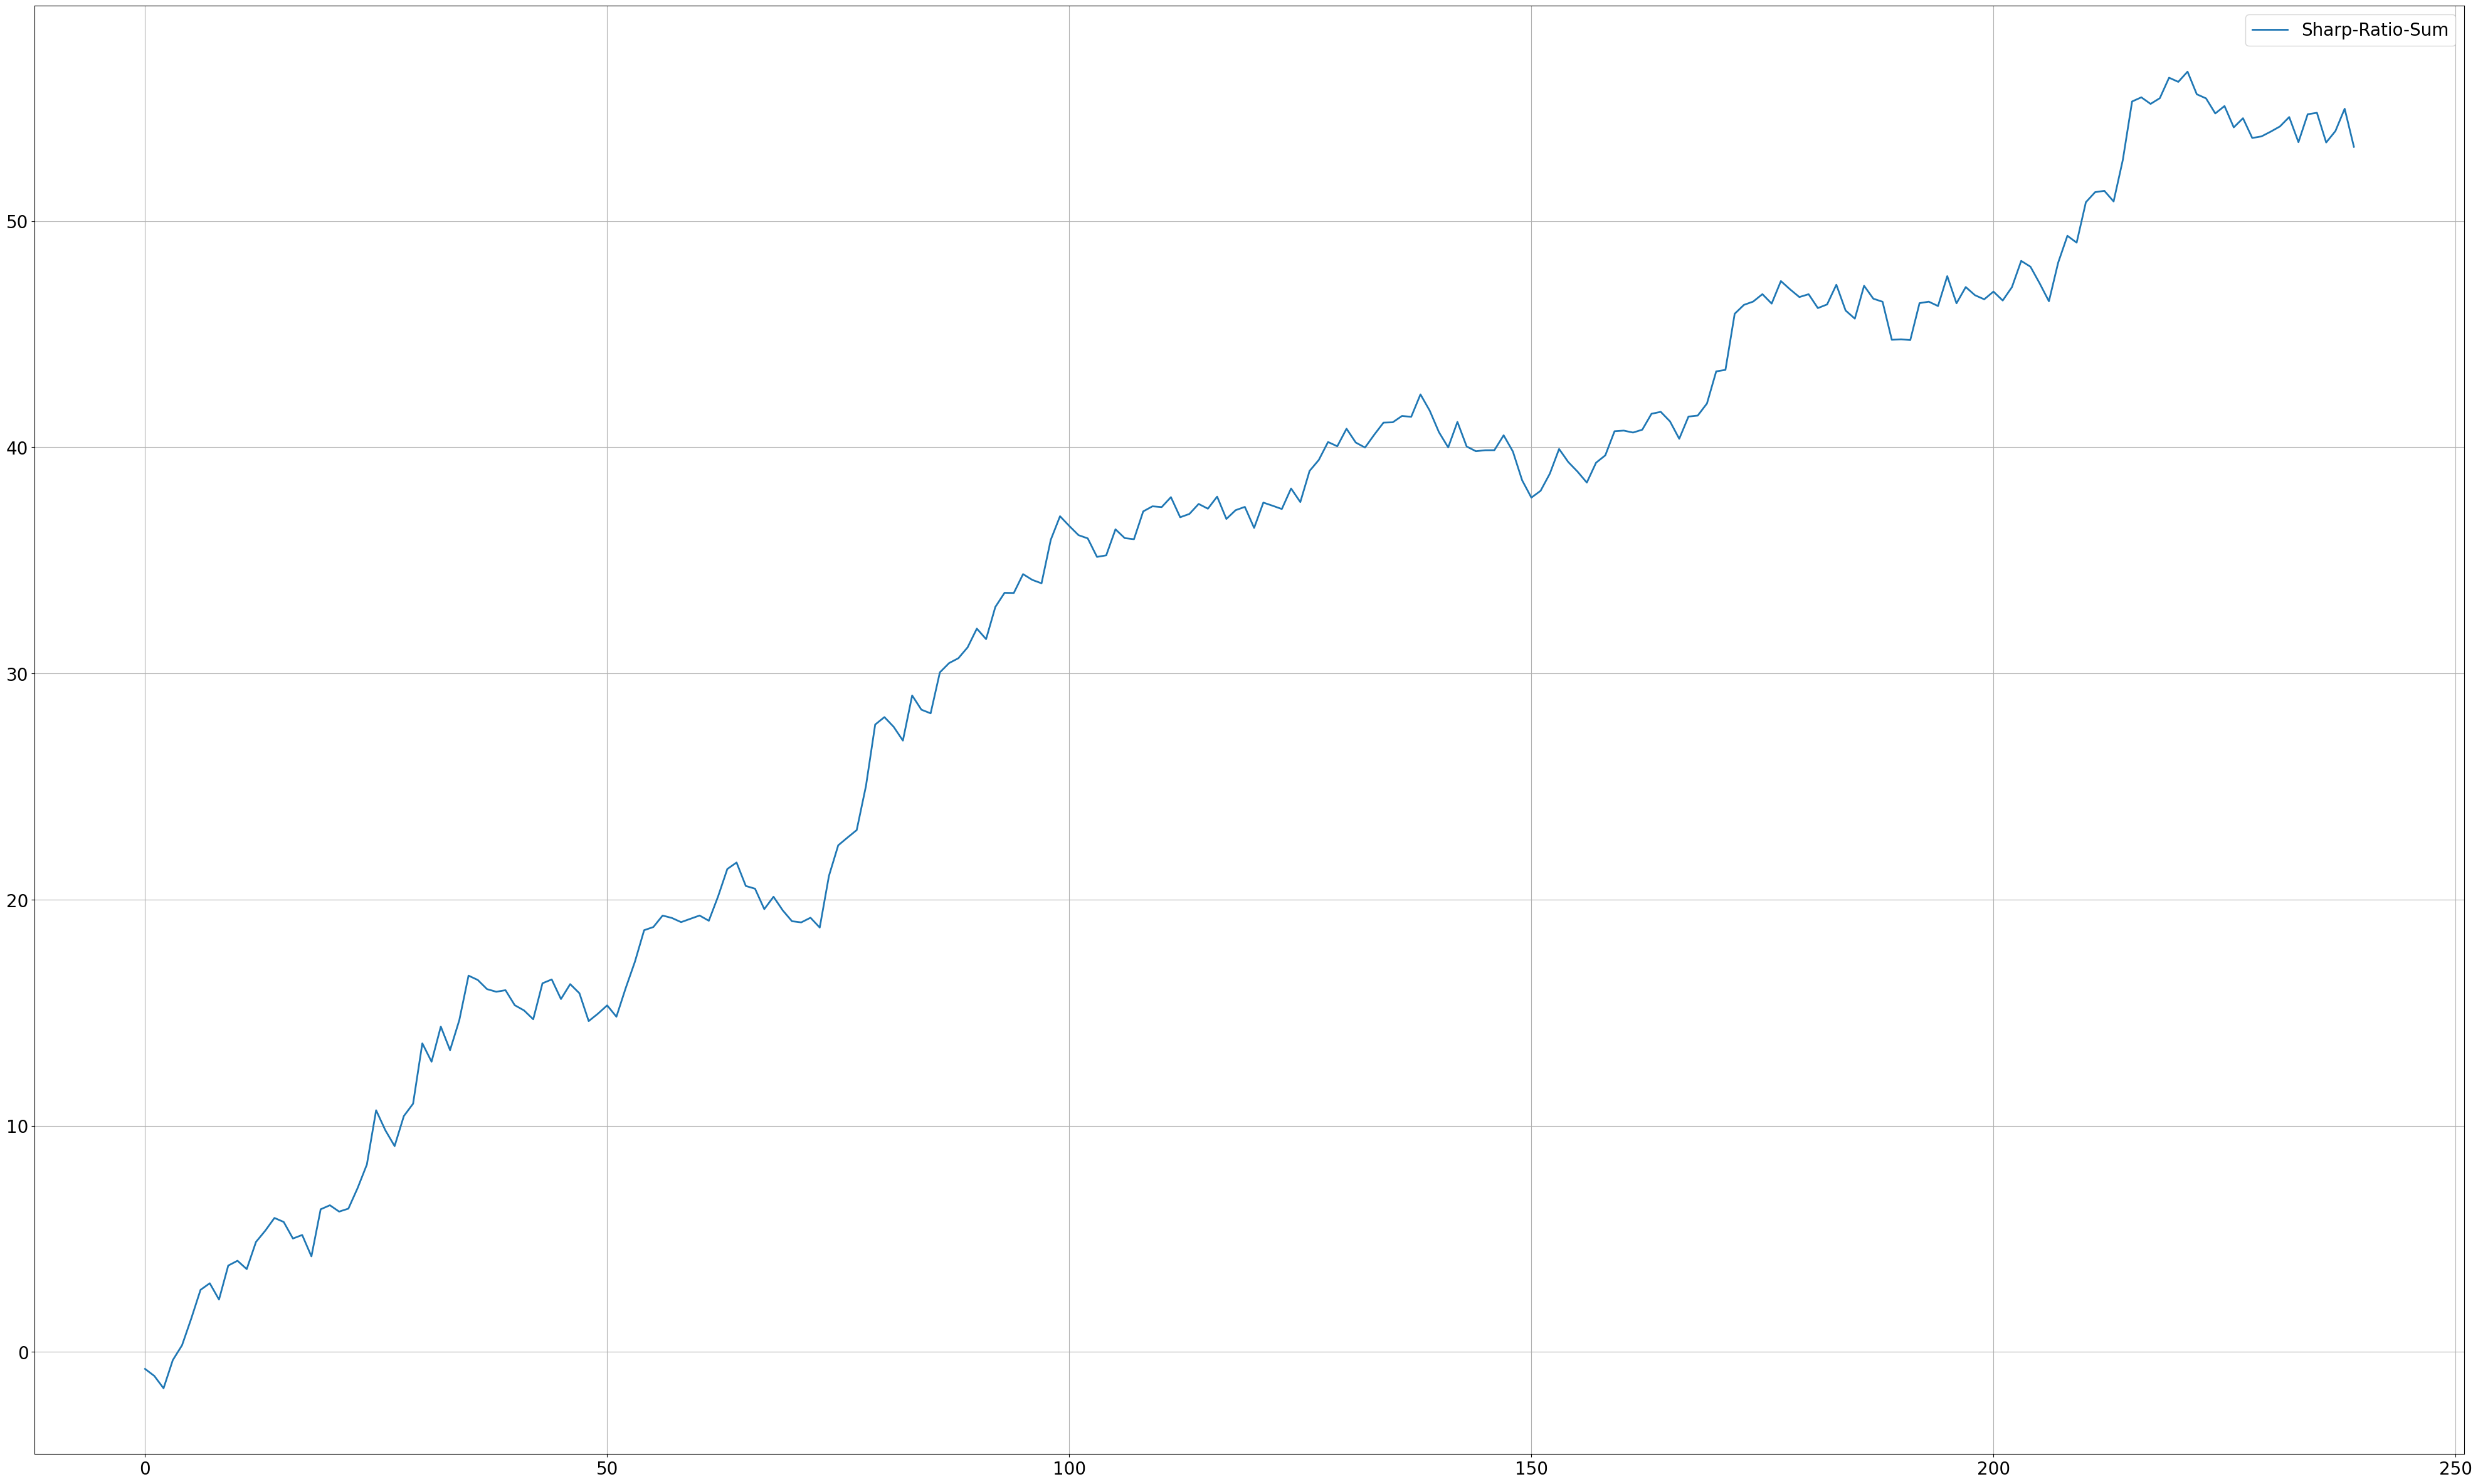

In [16]:
measure_name = 'asset-amount'

df_a2c = df_a2c.sort_values(by=['eod_date'], ascending=True)
df_a2c['yyyymm'] = df_a2c['eod_date']
df_a2c['yyyymm'] = df_a2c['yyyymm'].astype(str)
df_a2c['yyyymm'] = df_a2c['yyyymm'].str[0:6]

df_a2c['yesterday'] = df_a2c[measure_name].shift(1)
df_a2c = df_a2c.tail(df_a2c.shape[0] - 1)
df_a2c['profit'] = (df_a2c[measure_name] - df_a2c['yesterday']) / df_a2c['yesterday']

list_a2c_sharp = list()
for yyyymm in df_a2c['yyyymm'].unique():
    df_a2c_part = df_a2c[df_a2c['yyyymm'] == yyyymm]
    price_tail = float(df_a2c_part.tail(1)[measure_name].tolist()[0])
    price_head = float(df_a2c_part.head(1)[measure_name].tolist()[0])
    list_a2c_sharp.append({
        'YYYYMM': int(yyyymm),
        'PRICE_FIRST': price_head,
        'PRICE_LAST': price_tail,
        'PROFIT': (price_tail - price_head) / price_head,
        # 'PROFIT': numpy.mean(df_kospi_part['profit']) * 30,
        'VARIANCE': numpy.std(df_a2c_part['profit']) * numpy.sqrt(30),
    })
df_a2c_sharp = pandas.DataFrame(list_a2c_sharp)
df_a2c_sharp = df_a2c_sharp[df_a2c_sharp['YYYYMM'] >= 200301]
df_a2c_sharp['Sharp-Ratio'] = df_a2c_sharp['PROFIT'] / df_a2c_sharp['VARIANCE']
df_a2c_sharp['Sharp-Ratio-Sum'] = df_a2c_sharp['Sharp-Ratio'].cumsum()
display(df_a2c_sharp)
df_a2c_sharp.to_csv('data-0305-a2c.csv', index=None)
df_a2c_sharp_plot = df_a2c_sharp[['Sharp-Ratio-Sum']]
df_a2c_sharp_plot.plot()

df_a2c_result = df_a2c_sharp[['YYYYMM', 'Sharp-Ratio-Sum']]
df_a2c_result = df_a2c_result.set_index(['YYYYMM'])
df_a2c_result.columns = ['A2C']
df_all = df_all.join(df_a2c_result, how='left')

<Axes: xlabel='ts'>

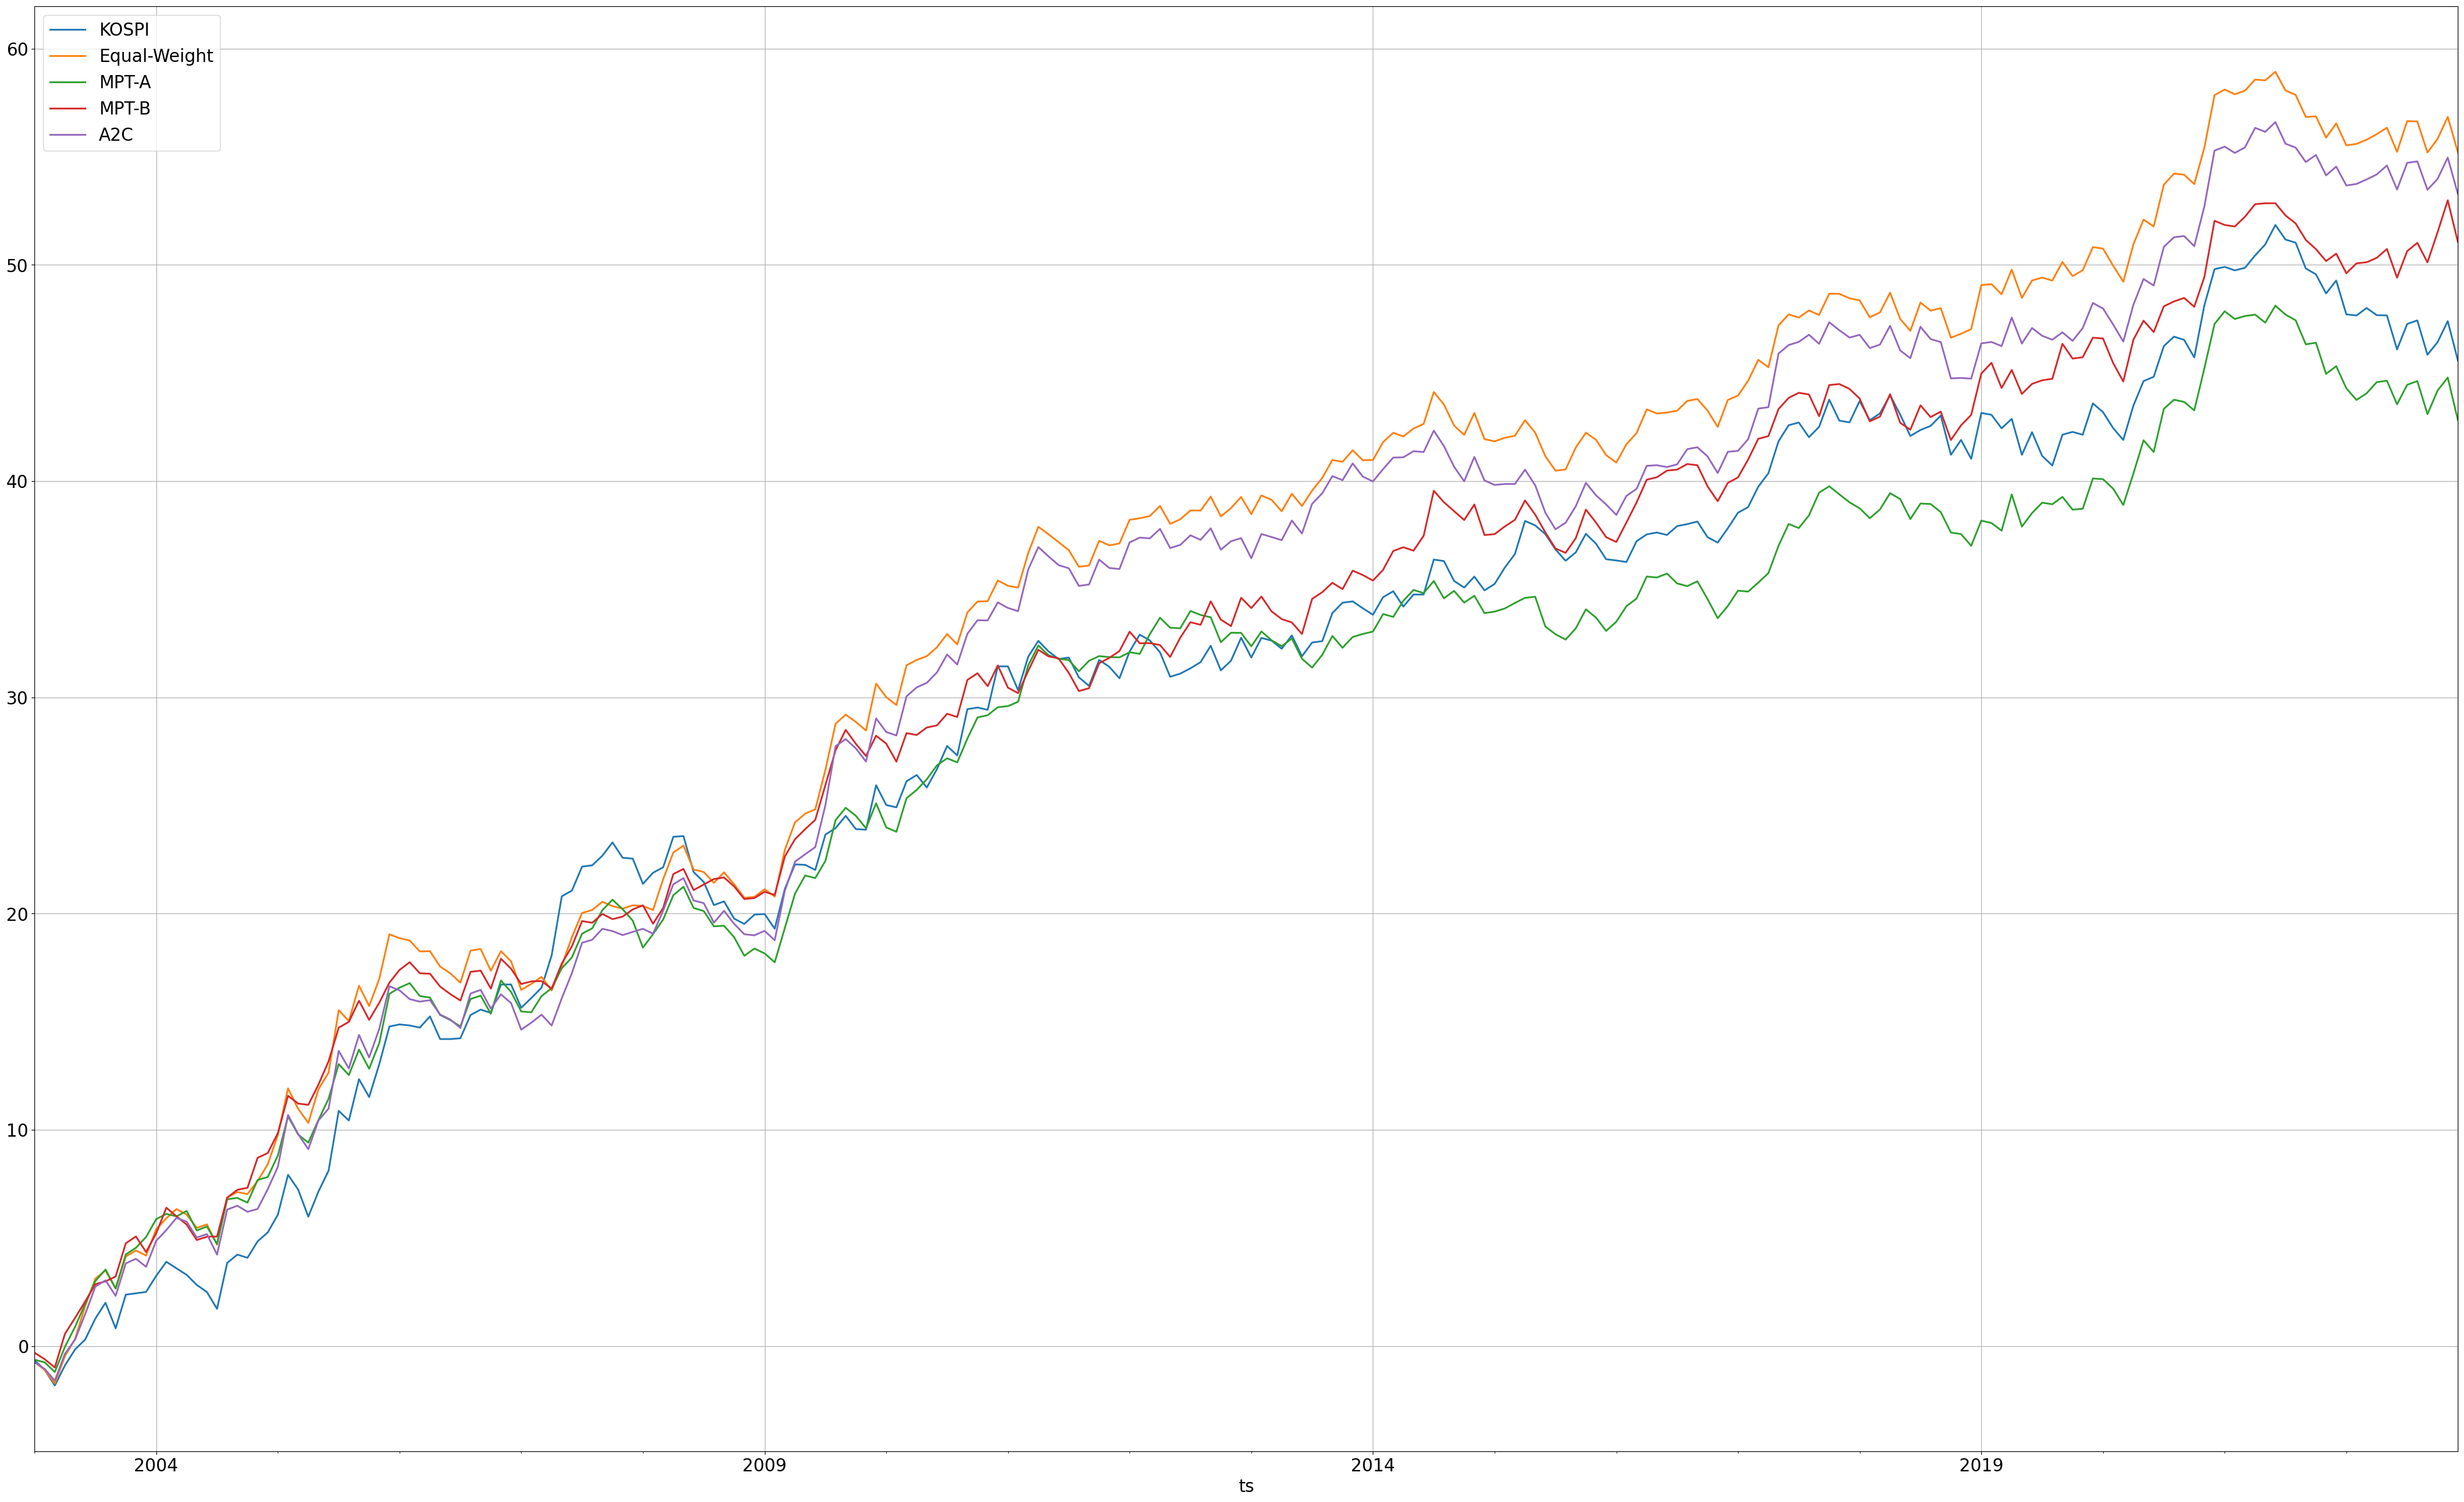

In [17]:
df_all_plot = df_all.copy()
df_all_plot['ts'] = pandas.to_datetime(df_all.index, format='%Y%m')
df_all_plot = df_all_plot.set_index(['ts'])
df_all_plot.plot()